# Test question generation on Reddit comments
We've collected valid questions from several advice subreddits and their corresponding posts.

Now let's try to generate the questions!

In [1]:
## load question data
import pandas as pd
question_data = pd.read_csv('../../data/reddit_data/subreddit_combined_valid_question_data.gz', sep='\t', compression='gzip', index_col=False)
print(question_data.shape[0])
display(question_data.head())

818557


,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit,question,valid_question_prob,info_question,post_question_overlap,post_question_overlap_score,post_question_overlap_sent
0,HindsightGraduate,NaN,t2_2xbcyguc,"Yes, YWBTA. People can be very black-and-white...",1.569354e+09,False,f1cajdw,d8pbuz,3.0,AmItheAsshole,Is there a solid impression she does that make...,0.810461,False,"(0.1, (['I', 'know', 'for', 'a', 'fact', 'that...",0.1,"['I', 'know', 'for', 'a', 'fact', 'that', 'she..."
1,jeliaser,NaN,t2_1eb2ir3n,Here's my opinion as a California Real Estate ...,1.566335e+09,False,exitsc7,csztdi,2.0,legaladvice,Likelihood of this being just a bluff?,0.526323,False,"(0.1, (['I', '’', 'm', 'contact', 'a', 'lawyer...",0.1,"['I', '’', 'm', 'contact', 'a', 'lawyer', 'abo..."
2,DamonTheron,NaN,t2_yyh3u,Water is 90 a month? Hot damn USA is expensive...,1.531750e+09,1531752032,e2hcc2w,8zarr7,1.0,personalfinance,Water is 90 a month?,0.599035,False,"(0.1, (['credit', 'score', 'is', '534', 'I', '...",0.1,"['credit', 'score', 'is', '534', 'I', 'think',..."
3,0000udeis000,Asshole Aficionado [17],t2_10j4wv,INFO: is your boss legally allowed to fire you...,1.574778e+09,False,f8sdvtb,e1yep5,1.0,AmItheAsshole,INFO: is your boss legally allowed to fire you...,0.599035,True,"(0.1, (['My', 'wife', 'is', 'realli', 'mad', '...",0.1,"['My', 'wife', 'is', 'realli', 'mad', 'and', '..."
4,tonytroz,NaN,t2_4apcg,The reason this can be VERY bad is because you...,1.531747e+09,False,e2h9sw2,8zatsc,2.0,personalfinance,Instead of being miserable for 3 months why no...,0.557299,False,"(0.1, (['If', 'someth', 'doesn', ""'"", 't', 'ch...",0.1,"['If', 'someth', 'doesn', ""'"", 't', 'chang', '..."


In [2]:
## add submission data
import json
import gzip
submission_data = pd.DataFrame([json.loads(x.strip()) for x in gzip.open('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', 'rt')])
submission_data.rename(columns={'id' : 'parent_id', 'selftext' : 'parent_text', 'title' : 'parent_title', 'author' : 'parent_author', 'edited' : 'parent_edited'}, inplace=True)
display(submission_data.head())

,parent_author,author_flair_text,created_utc,parent_edited,parent_id,num_comments,score,parent_text,subreddit,parent_title,category,author_fullname
0,deepsouthsloth,None,1514764840,False,7nby0l,7,1,26M/married/2 kids\n\nEmployer match is 50% up...,personalfinance,Should I continue with 401k despite terrible e...,NaN,NaN
1,CapableCounteroffer,None,1514764890,False,7nby5t,5,0,"On November 24th, I called AT&amp;T to inquire...",legaladvice,[FL] Issue getting AT&amp;T to pay early termi...,NaN,NaN
2,pinkcrayon69,None,1514764948,False,7nbybf,9,3,I live in south OC but I need to move out of m...,personalfinance,I need to move out in a month. What should I p...,NaN,NaN
3,bobshellby,Needs 64bit Windows...,1514765040,False,7nbykz,6,0,Are there keycaps for the Microsoft wireless k...,pcmasterrace,Keyboard keycap help,NaN,NaN
4,j0sh135742,None,1514765064,1.51477e+09,7nbyno,4,0,"So in MGL Part 1, Title 15, Chapter 94G, Secti...",legaladvice,Quick question about Medical Marijuana.,NaN,NaN


In [11]:
edited_submission_data = submission_data[submission_data.loc[:, 'parent_edited'].apply(lambda x: type(x) is int)]
display(edited_submission_data.loc[:, 'parent_text'].head(20).values)

array(['Me and my girlfriend live together in a duplex where the rent is around $450 (plus electric and water this is about $600). My girlfriend makes around $800 a month at her job. And I make around $400. We have a car payment that is $341.40 as well as the insurance which is $121.00 . My girlfriend is depressed and we don’t have enough to get her any help. \n\nI need help figuring out how to make our quality of life any better at all. Idk if we are allowed to apply for welfare or even how to start that process. Any advice would be greatly appreciated !\n\nUpdate: thank all of y’all for the advice and I appreciate the time. I’m sorry I couldn’t directly respond to all but I’ve been inspired. God bless.',
       'I\'ve been trying to think of how to condense this question so it\'s more palatable for a quicker response, but I\'m at a loss, so I hope somebody is willing to read this novel-length post.\n\nMy fiancee lives in New York state. Due to severe PTSD and mental illness, she has 

It looks like most of the edits will be too hard to identify automatically, so we will remove all edited submissions for now.

In [12]:
non_edited_submission_data = submission_data[submission_data.loc[:, 'parent_edited'].apply(lambda x: type(x) is bool and not x)]
print(f'{non_edited_submission_data.shape[0]}/{submission_data.shape[0]} non-edited posts')

796557/974252 non-edited posts


In [13]:
pd.set_option('display.max_colwidth', 100)
question_submission_data = pd.merge(
    question_data.loc[:, ['author', 'edited', 'id', 'subreddit', 'question', 'parent_id']],
    non_edited_submission_data.loc[:, ['parent_id', 'parent_text', 'parent_title', 'parent_edited']],
    on='parent_id',
)
print(question_submission_data.shape[0])
display(question_submission_data.head(10))

519557


,author,edited,id,subreddit,question,parent_id,parent_text,parent_title,parent_edited
0,HindsightGraduate,False,f1cajdw,AmItheAsshole,Is there a solid impression she does that makes you crack up every single time?,d8pbuz,"So my friend keeps asking people if they find her ugly, she’s done this to me once and also many...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and ...",False
1,TaKiDaLo,False,f1cmnoh,AmItheAsshole,But why do you keep asking this?,d8pbuz,"So my friend keeps asking people if they find her ugly, she’s done this to me once and also many...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and ...",False
2,rachelsnipples,False,f1ch41g,AmItheAsshole,"""Why are you asking me this?",d8pbuz,"So my friend keeps asking people if they find her ugly, she’s done this to me once and also many...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and ...",False
3,bigsisthrowaway19,False,f1cfiy5,AmItheAsshole,Why do you think she's asking?,d8pbuz,"So my friend keeps asking people if they find her ugly, she’s done this to me once and also many...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and ...",False
4,givebusterahand,False,f1dahgg,AmItheAsshole,What is telling her the truth going to do besides further destroy her self esteem?,d8pbuz,"So my friend keeps asking people if they find her ugly, she’s done this to me once and also many...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and ...",False
5,TripleV420,False,f1d2ms7,AmItheAsshole,Why don't you try to find ways to bring out her beauty?,d8pbuz,"So my friend keeps asking people if they find her ugly, she’s done this to me once and also many...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and ...",False
6,DK_Son,False,f1d5ej9,AmItheAsshole,"Or ""Do you think I'm a bitch?",d8pbuz,"So my friend keeps asking people if they find her ugly, she’s done this to me once and also many...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and ...",False
7,starjumper_,False,f1df88g,AmItheAsshole,It's not difficult to see the beauty in your friends so why not try it and tell her about it?,d8pbuz,"So my friend keeps asking people if they find her ugly, she’s done this to me once and also many...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and ...",False
8,velveteen279,False,f1csy7k,AmItheAsshole,Maybe ask her why she's feeling so shit about herself?,d8pbuz,"So my friend keeps asking people if they find her ugly, she’s done this to me once and also many...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and ...",False
9,Pastelroots,False,f1d0adj,AmItheAsshole,Why don't you suggest to your friend ways to look better instead of telling them their ugly?,d8pbuz,"So my friend keeps asking people if they find her ugly, she’s done this to me once and also many...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and ...",False


In [14]:
## clean up columns
question_submission_data.rename(columns={'parent_text' : 'article_text', 'parent_id' : 'article_id', 'parent_title' : 'article_title'}, inplace=True)
## clean up text
import re
info_question_matcher = re.compile('^INFO:? ')
submission_text_matcher = re.compile('^(AITA|WIBTA)|[\n\r]')
question_submission_data = question_submission_data.assign(**{
    'question' : question_submission_data.loc[:, 'question'].apply(lambda x: info_question_matcher.sub('', x)),
    'article_text' : question_submission_data.loc[:, 'article_text'].apply(lambda x: submission_text_matcher.sub('', x)),
    'article_title' : question_submission_data.loc[:, 'article_title'].apply(lambda x: submission_text_matcher.sub('', x)),
})

In [19]:
## get sample!! otherwise training takes weeks lol
import numpy as np
np.random.seed(123)
sample_pct = 0.10
N_sample = int(sample_pct*question_submission_data.shape[0])
print(f'sampling {N_sample} posts')
sample_question_data = question_submission_data.loc[np.random.choice(question_submission_data.index, N_sample, replace=False), :]

sampling 51955 posts


Let's convert all the data to tensor format so that we can train/test in Torch.

In [20]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import prepare_question_data
# from transformers import AutoTokenizer
from transformers import BartTokenizer
data_dir = '../../data/reddit_data/'
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir=data_dir)
data_name = 'advice_subreddit'
train_pct = 0.9
max_source_length = 512
max_target_length = 64
data_vars = ['article_text', 'question', 'article_id', 'article_title']
prepare_question_data(sample_question_data, data_dir, data_name, tokenizer, 
                      train_pct=train_pct, 
                      data_vars=data_vars,
                      max_source_length=max_source_length,
                      max_target_length=max_target_length)

Dataset csv downloaded and prepared to /home/ianbstew/.cache/huggingface/datasets/csv/default-15c3f3e37a707338/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.


Dataset csv downloaded and prepared to /home/ianbstew/.cache/huggingface/datasets/csv/default-38f758c32da96e5e/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.


### Test model output
After training (10% of data, ~15 hours), let's see how well-formed the questions seem to be for the test data.

In [ ]:
## set CUDA device
!export CUDA_VISIBLE_DEVICES=0

In [2]:
import torch
val_data = torch.load('../../data/reddit_data/advice_subreddit_val_data.pt')['train']
print(len(val_data))
print(val_data)

5287
Dataset(features: {'article_id': Value(dtype='string', id=None), 'article_title': Value(dtype='string', id=None), 'source_text': Value(dtype='string', id=None), 'target_text': Value(dtype='string', id=None), 'source_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'target_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 5287)


In [4]:
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
model_file = '../../data/reddit_data/text_only_model/question_generation_model/checkpoint-116500/pytorch_model.bin'
model_weights = torch.load(model_file)
generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir='../../data/model_cache/')
generation_model.load_state_dict(model_weights)
model_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir='../../data/model_cache/')

In [5]:
from data_helpers import generate_predictions
device_name = 'cuda:0'
generation_method = 'beam_search'
num_beams = 8
val_data_pred = generate_predictions(
    generation_model, val_data, model_tokenizer, 
    device_name=device_name, generation_method=generation_method,
    num_beams=num_beams,
)

  0%|          | 0/5287 [00:00<?, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
100%|██████████| 5287/5287 [16:19<00:00,  5.40it/s]


In [6]:
## write to file!!
import gzip
pred_out_file = '../../data/reddit_data/advice_subreddit_val_data_pred.gz'
with gzip.open(pred_out_file, 'wt') as pred_out:
    pred_out.write('\n'.join(val_data_pred))

In [5]:
from rouge_score import rouge_scorer
# print(help(rouge_scorer))
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
score = scorer.score('this is a test sentence', 'this is a test sentences to try out')
print(score)

{'rougeL': Score(precision=0.625, recall=1.0, fmeasure=0.7692307692307693)}


In [7]:
## compare predicted data vs. true data
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import compare_pred_text_with_target
cutoff_idx = 100
max_txt_len = 400
extra_data_vars = ['article_id', 'article_title']
compare_pred_text_with_target(val_data, val_data_pred, model_tokenizer, 
                              max_txt_len=max_txt_len, cutoff_idx=cutoff_idx,
                              extra_data_vars=extra_data_vars)

*~*~*~*~*~*
article_id = cz2ri6
article_title =  for refusing to give my girlfriend money because I earn more than her
source text = I've (M24) been with my girlfriend (F25) for almost 8 years (practically married, I know) and we have lived together for 5 years. After my graduation I landed a full time job in IT at an Oil &amp; Gas firm.My girlfriend is working at a supermarket part time and due to non-guaranteed hours her pay fluctuates quite dramatically from time to time.My girlfriend graduated in this year in 2019 with a Ma...
target text = What's the point of money if you can't even spend it on what matters the most to you?
pred text = What sort of degree is she getting?
*~*~*~*~*~*
article_id = d42wf4
article_title =  for telling kids at my old High School that most teachers there are useless and that they need to depend on themselves?
source text = I (32M) left my High School 14 years ago. In the UK, we refer to High School as Secondary School. Same thing basically. I stayed at 

*~*~*~*~*~*
article_id = as7mkw
article_title =  for wearing a sports bra when I run outside?
source text = I like to wear a sports bra top when I do a running workout outside (weather permitting). My husband would prefer I didnt, and wore a shirt over. AITA?To support his opinion: To be fair, I am from the US originally, but we have emigrated elsewhere. There is not so much a workout/fitness culture here, and in all honesty, I dont think Ive ever seen anyone working out in just a sports bra...maybe onc...
target text = Is it worth it?
pred text = Also, are you wearing a sports bra?
*~*~*~*~*~*
article_id = b2za6i
article_title =  for sending my kid to school with "adult" snacks and lunches?
source text = Living a healthy lifestyle is important to me, and it's important to pass it onto my kids as well. I have a second grader who I have brought up (so far) to be very involved in the kitchen, what we eat, diet and exercise. She came home with a note from her teacher the other day asking 

*~*~*~*~*~*
article_id = dv9ogm
article_title =  for asking my husbands sister to consider being a surrogate for us?
source text = My husband and I have been trying for pregnancy for years now, and to cut a long story short it seems as though it will never be a possibility. It took a long time to come to terms with but we've gradually got there. Our entire family is aware of the journey we've been on and how much it meant to us. With that in mind, my husband and I came to his sister (Sarah) with a proposal.Sarah is in her ear...
target text = Because for something to spiral that far out of control needs more than "will you surrogate?
pred text = Didn't you say she should have made it clear that she wasn't sure?
*~*~*~*~*~*
article_id = 8ime01
article_title = I have finally become the "techguy" in the family... FML
source text = I get the blame for literally everything that goes wrong. I mean *EVERYTHING*.My aunt bought a laptop 10 years ago, and somehow ***I*** got the blame for the in

*~*~*~*~*~*
article_id = chlcbo
article_title =  for refusing to allow my daughter to participate in High School cheerleading?
source text = I have a son thats entering 8th grade and a daughter thats entering 9th grade.  Both of them have always been bookworms.  Very studious and cerebral, just like their Dad.  I also played sports all through school and I value the experience that brings.  I've always tried to push them to join sports, but neither one of my kids wanted to.  I tried to insist...maybe they would have fun?  We dont know ...
target text = Does the school have a cross-country team?
pred text = YTA you wanna be a cheerleader in high school?
*~*~*~*~*~*
article_id = 8ohr1y
article_title =  for breaking off a friendship over rent?
source text = I just found out yesterday that a good friend/roommate of mine has been dicking me over by charging me extra rent for a year and a half. He didn't just dick me over, he dicked three other people who lived in the house too. When confron

*~*~*~*~*~*
article_id = bhmv9b
article_title =  for forcing my girlfriend to eat healthier?
source text = I know this sounds like a SHP or too fishing, but hear me out.Since she was a kid, my girlfriend has been a very picky eater. She was admittedly a spoiled princess who ate nothing but meat and sweets whenever she liked. She told me that her also never liked fruits and veggies, so their entire household really wasn't into the whole "healthy eating" thing.When we first dated, I already knew this.I a...
target text = How is her diet affecting you?
pred text = NTA- If you can't find a healthy lifestyle, then what are you going to do?
*~*~*~*~*~*
article_id = 8zck5h
article_title = New hire NOOB looking for investment options. Should I enroll in Roth 401K or Traditional 401K?
source text = I am a new hire starting work this week. My income will be around $100K before taxes in California, probably around $70K after taxes.I have the option to enroll in my company's 401K with fidelity, bu

*~*~*~*~*~*
article_id = ccl4an
article_title =  for going on a trip instead of focusing my time and money on the family to-be?
source text =  The family doesn't exist yet. It was pretty obvious that he was ready for a family soon after we started dating but we hadn't started *really* talking about it until earlier this year. I've never wanted a family, I've never aspired to be a mother, and I didn't see this coming up so soon. We've been dating for a year, we were only seeing each other for a couple months before our status became rath...
target text = You're barely warming up to the idea of a family one day and he's trying to control how you spend your time and money now because you may or may not have kids some day?
pred text = You have been together for how long, moved in together, planned and paid for 6 months, and you have never wanted to even start a family?
*~*~*~*~*~*
article_id = cw34du
article_title =  for showing no sympathy to my daughter through a difficult time?
source t

*~*~*~*~*~*
article_id = djdmik
article_title =  for being angry with my in-laws?
source text = My in-laws are planning a family vacation to go down south (we live in Canada), where they pay for their kids to go, but significant others have to pay for themselves. That's fine, except we have a 6 month old and aren't comfortable traveling with him, so we talked to them about how we wouldn't be going and that's fine. Recently one of my sister in law's let us know when the vacation would be happ...
target text = NTA - What kind of shitty family purposefully schedule a vacation over their grandchild/nephew's first birthday?
pred text = Also, if they've been in the country for 6 months, how were they supposed to know the time off?
*~*~*~*~*~*
article_id = cz5vk2
article_title =  for refusing to use the money I inherited from my mother to pay for medical treatment for my half-sister, who has a life threatening sickness? She is the child of my father and the woman he cheated on my mother with.

- No cases of data bleeding? Seems good to me.
- Reasonable:
    - Submission title: `20 years old. ~45-50k a year. Great credit, 6% contribution to 401k with 6% match. What am I saving for?`
        - Target: `What would you like to do?`
        - Predicted: `And what do you do for fun when you don't have a job?`
    - Submission title: `Online Services, Chargeback attempt, customer threatens me with police`
        - Target: `So let me get this straight: Someone hired you to plagiarize his school work for him, presumably you know this person's real name and the name of the school he goes to, and now this person's decided to threaten *you* with police if you don't let him keep the work you did for`
        - Predicted: `By the way, do you have proof of his chargeback?`
    - Submission title: `I'm about to spend 37,000 on new computers, and I'm freaking worried.`
        - Target: `Also, do you really need 2tb?`
        - Predicted: `What kind of components are you looking for?`
    - Submission title: `Confusion regarding language of vacation time - Employer wants me to pay back "non-vested" vacation. Michigan, USA.`
        - Target: `Are you certain that theyre looking for pay back of vacation days you already used?`
        - Predicted: `How many employees does the company have?`
    - Submission title: `Review my situation?`
        - Target: `Why a 100k car?`
        - Predicted: `What is your annual income?`
- Ungrammatical:
    - Submission title: `Won a brand new SUV (Volvo XC60) from a video contest. Want to sell it! What should I do?`
        - Target: `Did you ever receive the car?`
        - Predicted: `prizes for a prize?`
    - Submission title: `for completely ignoring my father’s girlfriend`
        - Target: `He YELLED my name and I looked around confused like "there's nobody in this class by that name?`
        - Predicted: `mixes you up all the time?`
- Logically incorrect:
    - Submission title: `Grandpa PC Troubles (Please Help)`
        - Target: `Ddr2 or whatever the Mobo is able to use?`
        - Predicted: `What kind of budget did he have for the upgrade?`
    - Submission title: `I have finally become the "techguy" in the family... FML`
        - Target: `Why don't you tell them to fuck off?`
        - Predicted: `Why do you need a computer in the first place?`
- Repetitive:
    - Submission title: `for telling my sister who is getting a boob job that fake boobs are gross?`
        - Target: `You think fake boobs change the personality of the owner?`
        - Predicted: `She's getting a boob job in December?`
    - Submission title: `Should I call CPS?`
        - Target: `The bigger question is how would you feel some day if you see a newspaper with a picture of a building in your complex and EMTs talking about how a child died of neglect?`
        - Predicted: `Or do you yell at the top of your lungs when the baby is crying?`
- Inappropriate:
    - Submission title: `for refusing to pay back my cousin after my baby ruined her blouse?`
        - Target: `What is with these stories of there being a 3rd party conversation after the fact where they decide you owe somebody something?`
        - Predicted: `How the fuck is that even a question?`

### Look at high-scoring and low-scoring questions
Let's have a look at the questions that scored highest and lowest according to BLEU and ROUGE.

In [1]:
## load data
import pandas as pd
val_data = pd.read_csv('../../data/reddit_data/advice_subreddit_val_data.csv', sep=',', index_col=False)
print(val_data.shape)
## get trained generation output
import gzip
train_model_output_data = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
print(len(train_model_output_data))
## get zero-shot generation output
zero_shot_output_data = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/no_train_model/test_data_output_text.gz', 'rt')))
print(len(zero_shot_output_data))

(5287, 4)
5287
5287


In [2]:
## combine data
output_data = pd.DataFrame([
    train_model_output_data,
    zero_shot_output_data
    ], index=['text_only_output', 'zero_shot_output'], columns=val_data.index).transpose()
test_data = pd.concat([
    val_data.loc[:, ['source_text', 'target_text', 'article_id']],
    output_data,
], axis=1)
display(test_data.head())

,source_text,target_text,article_id,text_only_output,zero_shot_output
0,I've (M24) been with my girlfriend (F25) for a...,What's the point of money if you can't even sp...,cz2ri6,What sort of degree is she getting?,I've (M24) been with my girlfriend (F25) for a...
1,I (32M) left my High School 14 years ago. In t...,As opposed to a dick-measuring contest of impo...,d42wf4,What do you think it’s really like?,I (32M) left my High School 14 years ago. In t...
2,Lot's of stuff to unpack here...using a throwa...,Is this your wife's brother?,ag8qzp,You didn't get to see how this would go?,Lot's of stuff to unpack here...using a throwa...
3,"To preface, I am not black, however I grew up ...",Do you say n****r or n***a?,9tv5c5,"I’m gonna go a step back and ask, “*****” really?","To preface, I am not black, however I grew up ..."
4,My sister (22F) informed our family over dinne...,Think you may just be a tad bit too invested i...,dsnsuc,She's getting a boob job in December?,My sister (22F) informed our family over dinne...


In [4]:
## compute overlap scores
from data_helpers import compute_text_bleu
from rouge_score.rouge_scorer import RougeScorer
rouge_scorer = RougeScorer(['rougeL'], use_stemmer=True)
bleu_weights = [1.0, 0., 0., 0.]
output_cols = ['text_only_output', 'zero_shot_output']
for output_col in output_cols:
    test_data = test_data.assign(**{
        f'{output_col}_BLEU' : test_data.apply(lambda x: compute_text_bleu(x.loc['target_text'], x.loc[output_col], weights=bleu_weights), axis=1),
        f'{output_col}_ROUGE' : test_data.apply(lambda x: rouge_scorer.score(x.loc['target_text'], x.loc[output_col])['rougeL'].fmeasure, axis=1),
    })

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

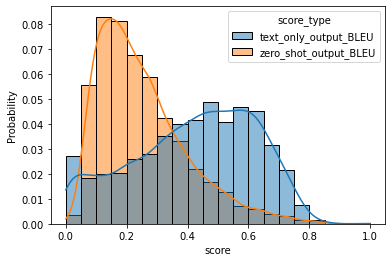

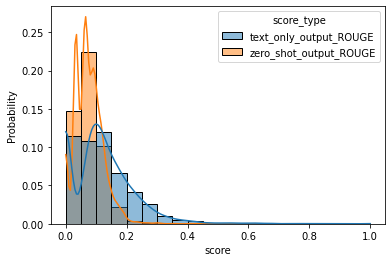

In [5]:
## plot distributions of scores
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
score_types = ['BLEU', 'ROUGE']
for score_type_i in score_types:
    score_cols = list(filter(lambda x: score_type_i in x, test_data.columns))
    flat_score_data_i = pd.melt(test_data.loc[:, score_cols], value_vars=score_cols, var_name='score_type', value_name='score')
    sns.histplot(x='score', hue='score_type', data=flat_score_data_i, bins=20, kde=True, stat='probability')
    plt.show()

The text-only model does consistently better than the zero-shot model. There is a surprising "bump" of bad questions for the text-only model (low-overlap), which we will investigate below.

In [6]:
pd.set_option('display.max_colwidth', 750)
## questions with high overlap
test_data.sort_values('text_only_output_ROUGE', inplace=True, ascending=False)
display(test_data.head(20))

,source_text,target_text,article_id,text_only_output,zero_shot_output,text_only_output_BLEU,text_only_output_ROUGE,zero_shot_output_BLEU,zero_shot_output_ROUGE
647,"I [23F] have this feeling that I can't shake that something is off in my life. As if what I'm doing isn't what i'm meant to be doing. I feel uncomfortable mentally, bored, and constantly restless--and unhappy. I get pangs of sadness and feelings of being trapped. Then again, I am 23 and don't know if this is common. Any advice?",What do you want?,8miprz,What do you want?,"I [23F] have this feeling that I can't shake that something is off in my life. As if what I'm doing isn't what i'm meant to be doing. I feel uncomfortable mentally, bored, and constantly restless--and unhappy. I get pangs of sadness and feelings of being",1.000000,1.000000,0.059055,0.072727
2347,My Father recently died. He Co-owned a condo in Florida with a random girlfriend. Does anyone here have advice as to how to deal with the property? I'm not even sure if they own it outright. Any advice would be helpful.,Did he have a will?,90i2wk,Did he have a will?,My Father recently died. He Co-owned a condo in Florida with a random girlfriend. Does anyone here have advice as to how to deal with the property? I'm not even sure if they own it outright. Any advice would be helpful.,1.000000,1.000000,0.086758,0.083333
3652,"I'm starting an emergency fund and to avoid having my money sit in the proverbial mattress i'm researching high interest savings/money market accounts. I found CIT an online bank that's FDIC insured and offers some (apparently) great interest rates [here](https://www.bankoncit.com/) with some conditions found [here](https://www.bankoncit.com/uploadedFiles/bankoncitcom/pages/Personal_Banking/Savings/SavingsBuilderFAQs.pdf). I've read through that PDF, please correct me if i'm wrong, this is what i'm understanding: * Need to deposit $100 to open the account and an additional $100 or more that first month to get an APY of 2.15%. * To maintain the 2.15% APY I need to deposit $100 or more every monthWhat's the difference between APY and inte...",&gt; What's the difference between APY and interest?,9v06iz,What's the difference between APY and APY?,I'm starting an emergency fund and to avoid having my money sit in the proverbial mattress i'm researching high interest savings/money market accounts. I found CIT an online bank that's FDIC insured and offers some (apparently) great interest rates [here](https://www.bankoncit.,0.731833,0.823529,0.161871,0.107143
3833,"I have been an Xbox player my entire life and I have always wanted to dive into the PC gaming world. I’ve watched so many videos on builds and what parts I need, but everything is still so confusing and I don’t know where to start. I need some help with choosing the perfect parts for the best price I can get. Any advice will help, thanks!",What is your budget and what games do you want to play?,c7wyl4,What is your budget and what do you want to do with it?,"I have been an Xbox player my entire life and I have always wanted to dive into the PC gaming world. I’ve watched so many videos on builds and what parts I need, but everything is still so confusing and I don’t know where to start. I need some help with choosing",0.836364,0.800000,0.202290,0.121212
668,Not sure how to approach this but have a significant amount of debt and wondering how to approach it with her as going to have lunch with her on Friday. Do I ask her to help pay off the entire credit card 8k and climbing with interest or also the bank loan of 12.5k. I don't wanna ask her for 20.5k check but maybe just credit card right?,What's your interest rate on the card and loan?,b3e894,What’s the interest rate on the cards?,Not sure how to approach this but have a significant amount of debt and wondering how to handle it with her as going to have lunch with her on Friday. Do I ask her to help pay off the entire credit card 8k and climbing with interest or also the bank loan of 12

- The highest-scoring questions are shorter, sometimes quotes, sometimes paraphrases.
    - Paraphrase
        - `source`: `I have been an Xbox player my entire life and I have always wanted to dive into the PC gaming world.`
            - `target`: `What is your budget and what games do you want to play?`
            - `generated`: `What is your budget and what do you want to do with it?`
        - `source`: `Not sure how to approach this but have a significant amount of debt and wondering how to approach it with her as going to have lunch with her on Friday.`
            - `target`: `What's your interest rate on the card and loan?`
            - `generated`: `What’s the interest rate on the cards?`


In [7]:
## questions with low overlap
test_data.sort_values('text_only_output_ROUGE', inplace=True, ascending=True)
display(test_data.head(20))

,source_text,target_text,article_id,text_only_output,zero_shot_output,text_only_output_BLEU,text_only_output_ROUGE,zero_shot_output_BLEU,zero_shot_output_ROUGE
2643,"Throwaway for anonymity sake incase this does go further. To preface this, I (24F) am vegan, and have been for a good 10 years. I have not eaten meat since I was roughly 3-4 years old when I found out where meat comes from (spoiler alert: there were a lot of tears). This is no secret and everyone in my life knows and respects this - or so I thought. Four nights ago, I was at a party and I will admit, I got white girl wasted. My friends thought it would be funny to feed me chicken nuggets as a prank. I checked with them before chowing down ""are these vegan?"" To which my friends replied ""yeah, they're sunfed"" (a type of vegan chickenless chicken). They tasted off to me but I figured it was just because I was drunk. I was wrong. I found ou...","If your excuse is alcohol allowed you to do something you wouldn’t normally do, why does that not apply to them as well?",devz7y,"It’s a shitpost, right?","Throwaway for anonymity sake incase this does go further. To preface this, I (24F) am vegan, and have been for a good 10 years. I have not eaten meat since I was roughly 3-4 years old when I found out where meat comes from (spoiler alert:",0.014737,0.0,0.462185,0.056338
1292,"Hey everyone! Some background: 27/F and 28/M. We're getting married in November. We both have good credit (&gt;700). Our combined annual income is ~85k.My Standing:94k owed on a 30 year mortgage. I put down all of the initial deposit (~75k).No car payment.No credit card debt (I pay off total balance each month).10k in Savings account (emergency fund).~30k in a mutual fund (interest on that goes into my Savings).Have Roth IRA set up because my employer does not offer a 401k with match. However, I haven't contributed to it yet.His Standing:No mortgage.13k owed on car.3k owed on credit cards.Nothing in Savings.Contributes to employer 401k to max match. Questions:-Is it too late to contribute to my Roth IRA? What will happen to it once we'r...",Which state will you marry in and be living in?,8kgesh,What's your budget look like?,Hey everyone! Some background: 27/F and 28/M. We're getting married in November. We both have good credit (&gt;700). Our combined annual income is ~85k.My Standing:94k owed on a 30 year mortgage. I put down all of the initial deposit (~,0.426351,0.0,0.194915,0.072727
1294,I know this isn't a heavy question like what usually shows up here but I do need some advice because I am rubbish in social situations... and the rules say we can ask for advice on any subject.So a silent but extremely stinky toot escaped me while at the laundromat. There is only one other person in the room. Obviously she knows it was me but she hasn't said anything. Do I apologize? Is that the polite thing to do or is it going to be more awkward?I'm not trying to be a twit. I am actually unsure on the social decorum in this situation.,Perhaps she didn’t even notice?,bvmdeb,Is it a common theme?,I know this isn't a heavy question like what usually shows up here but I do need some advice because I am rubbish in social situations... and the rules say we can ask for advice on any subject.So a silent but extremely stinky toot escaped me while at the laundromat. There is,0.473253,0.0,0.101818,0.033333
2479,"This happened like a few hours ago, and well, I feel conflicted.This is at a fast food restaurant FYISee, we have this shift manager that is in his 60s and a lot of people either don’t like him or feel comfortable around him. I’m the person who doesn’t like him or feel comfortable around him.Anyways, he was expediting the items (bagging them) and he decided to put 3 large sandwiches (one of them a double) and the carton of onion rings in with it to. When I grabbed it from him, it started to rip and I immediately held it up to keep it from ripping. The following conversation is said.Me: You know, maybe for future

The lowest scoring questions are still reasonable, just not on the same topic.
- Off-topic:
    - `source`: `I belong to India and we are currently in war like situation with our neighboring country, Pakistan`
        - `target`: `They are knowingly sharing fake news?`
        - `generated`: `Is it so bad that you have to leave the group?`
    - `source`: `My first divorce attorney has already quit over this so I know it’s a complicated issue.`
        - `target`: `How old is the child?`
        - `generated`: `What state are you in?`

Are some of the subreddits especially difficult in terms of questions asked?

In [8]:
## rejoin test data with subreddit info
from data_helpers import load_zipped_json_data
full_post_data = load_zipped_json_data('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz')
full_post_data.rename(columns={'id' : 'article_id'}, inplace=True)
full_post_data = pd.merge(
    full_post_data.loc[:, ['subreddit', 'article_id']],
    test_data, on='article_id'
)
display(full_post_data.head())

,subreddit,article_id,source_text,target_text,text_only_output,zero_shot_output,text_only_output_BLEU,text_only_output_ROUGE,zero_shot_output_BLEU,zero_shot_output_ROUGE
0,personalfinance,7o3jgk,"I submitted a video for a video contest and was selected as a grand prize winner. It's a very reputable company so it's completely legit - I'm not concerned about that. The Prize is a brand new Volvo XC60 plus a 10K check to help cover the tax burden.I do not want to keep the car - I want to keep the most cash from the sale as possible. The contest organizer is working out a deal with a local dealership and I will be going to pick up the car from that dealer towards the end of January. Also, they did not offer a cash prize alternative.The questions I have are these:Should I take the car and try to sell it to a private party? Or try to sell it to a dealer? In either case, do I need to register the tag/title in my name and pay the taxes a...",Did you ever receive the car?,prizes for a prize?,I submitted a video for a video contest and was selected as a grand prize winner. It's a very reputable company so it's completely legit - I'm not concerned about that. The Prize is a brand new Volvo XC60 plus a 10K check to help cover the tax burden.I do not,0.404216,0.000000,0.104247,0.033333
1,legaladvice,7p7zg0,"I made a post a couple of months back.. I received overwhelming help and support from this sub, so I’m kindly asking again for your help. TL;DR version: I[m/27] was sexually harassed twice by a supervisor[m/59]. Both events were reported to HR. Four months later, the same man groped me and I resigned from the company.I sought legal action and a lawyer has been working on my case. Today he called me to tell me what’s posted in the title. He also let me know that they fired the supervisor but that had only happened recently (I resigned in October).I feel conflicted about possibly returning. I LOVED my coworkers but I’m afraid of retaliation from upper management or corporate and am skeptical if this is just their way of trying to get out ...","If you take your job back, who/how does your lawyer get paid?",Did you go over your manager / HR in person?,"I made a post a couple of months back.. I received overwhelming help and support from this sub, so I’m kindly asking again for your help. TL;DR version: I[m/27] was sexually harassed twice by a supervisor[M/59]. Both events were reported to HR",0.509643,0.181818,0.242798,0.065574
2,legaladvice,80wltl,"Follow up to this: https://www.reddit.com/r/legaladvice/comments/7z07go/mi_violated_parole_missed_court_due_to_late_mail/I have paid off all but $80 of my restitution, and left several messages with my PO, both phone, and email. Nothing is being returned. When I call the Probation department, they just say I need to speak with my PO.I can't get a hold of anyone, either in the criminal department, or administration. I want to get this taken care of, but it seems that anyone I talk to says they can't help me, only my PO can. But she won't talk to me.What can I do?Recap from last thread:* I pled no contest to Child endangerment, 4th degree. Got sentenced to 1 year in jail, in abeyance of 1 year probation. $2000/ fines, community se...",What court is your case out of?,You got a full year probation?,"Follow up to this: https://www.reddit.com/r/legaladvice/comments/7z07go/mi_violated_parole_missed_court_due_to_late_mail/I have paid off all but $80 of my restitution, and",0.709292,0.000000,0.168605,0.102564
3,legaladvice,811zh4,"I suppose this is a rather technical question. Hopefully, someone knows the answer. I was responsible for preparing a title policy. That policy didn't include an expensive lien. I failed to notice. At some point, someone may file a claim against my employer. Could that spell legal trouble for me? Could my employer come after me for the money they lose?",Dont they have O&amp;E insurance?,Did you have a title policy?,"I suppose this is a rather technical question. Hopefully, someo

subreddit = Advice
text-only score mean = 0.422 +/- 0.198


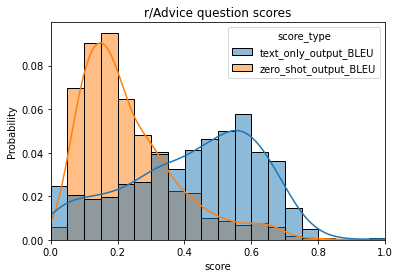

subreddit = AmItheAsshole
text-only score mean = 0.413 +/- 0.206


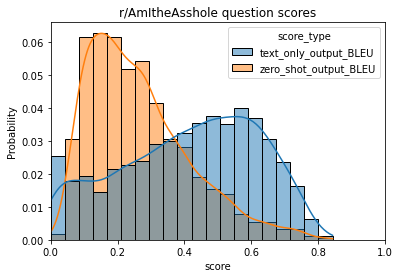

subreddit = legaladvice
text-only score mean = 0.432 +/- 0.202


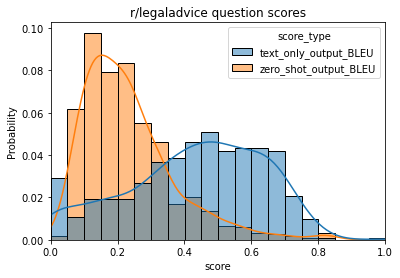

subreddit = pcmasterrace
text-only score mean = 0.440 +/- 0.180


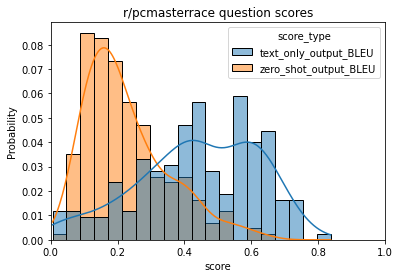

subreddit = personalfinance
text-only score mean = 0.422 +/- 0.196


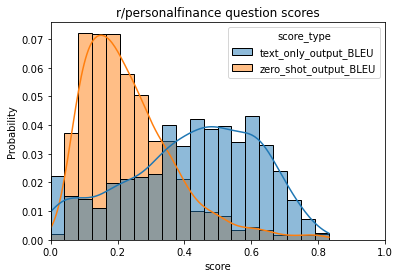

In [23]:
## plot distribution for all subreddits
import numpy as np
score_type = 'BLEU'
score_cols = list(filter(lambda x: score_type in x, full_post_data.columns))
for subreddit_i, data_i in full_post_data.groupby('subreddit'):
    print(f'subreddit = {subreddit_i}')
    scores_i = data_i.loc[:, f'text_only_output_{score_type}'].values
    print(f'text-only score mean = {"{:1.3f}".format(np.mean(scores_i))} +/- {"{:1.3f}".format(np.std(scores_i))}')
    flat_score_data_i = pd.melt(data_i.loc[:, score_cols], value_vars=score_cols, var_name='score_type', value_name='score')
    sns.histplot(x='score', hue='score_type', data=flat_score_data_i, bins=20, kde=True, stat='probability')
#     sns.boxplot(y='score', x='score_type', data=flat_score_data_i)
    plt.title(f'r/{subreddit_i} question scores')
    plt.xlim(0,1)
    plt.show()

- `pcmasterrace` has a bimodal distribution, perhaps due to specific components/companies that are mentioned or omitted from questions. 
- `AmItheAsshole` has an especially strong skew in generated questions toward 0, possibly because of generic questions that are hard to mimic (`Did you really say that?`)?

### Compare against "regular" question generation
We've trained a model to generate questions based on QA data from CNN ("clean" data), so let's see if that model provides a more reliable baseline against which to compare the full model.

In [9]:
## load data
import pandas as pd
val_data = pd.read_csv('../../data/reddit_data/advice_subreddit_val_data.csv', sep=',', index_col=False)
print(val_data.shape)
## get trained generation output
import gzip
train_model_output_data = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
print(len(train_model_output_data))
## get out-of-domain generation output
standard_model_output_data = list(map(lambda x: x.strip(), gzip.open('../../data/CNN_articles/cnn/test_data_output_text.gz', 'rt')))
print(len(standard_model_output_data))

(25523, 3)
5287
26238


In [2]:
## combine data
output_data = pd.DataFrame([
    train_model_output_data,
    standard_model_output_data
    ], index=['text_only_output', 'standard_output'], columns=val_data.index).transpose()
test_data = pd.concat([
    val_data.loc[:, ['source_text', 'target_text', 'article_id']],
    output_data,
], axis=1)
display(test_data.head())

,source_text,target_text,article_id,text_only_output,standard_output
0,I've (M24) been with my girlfriend (F25) for a...,What's the point of money if you can't even sp...,cz2ri6,What sort of degree is she getting?,Who is the girlfriend?
1,I (32M) left my High School 14 years ago. In t...,As opposed to a dick-measuring contest of impo...,d42wf4,What do you think it’s really like?,What was the school's name?
2,Lot's of stuff to unpack here...using a throwa...,Is this your wife's brother?,ag8qzp,You didn't get to see how this would go?,What did BIL say about the experience?
3,"To preface, I am not black, however I grew up ...",Do you say n****r or n***a?,9tv5c5,"I’m gonna go a step back and ask, “*****” really?",What did he say about black people?
4,My sister (22F) informed our family over dinne...,Think you may just be a tad bit too invested i...,dsnsuc,She's getting a boob job in December?,What did she tell her boyfriend?


In [3]:
## compute overlap scores
from data_helpers import compute_text_bleu
from rouge_score.rouge_scorer import RougeScorer
rouge_scorer = RougeScorer(['rougeL'], use_stemmer=True)
bleu_weights = [1.0, 0., 0., 0.]
output_cols = ['text_only_output', 'standard_output']
for output_col in output_cols:
    test_data = test_data.assign(**{
        f'{output_col}_BLEU' : test_data.apply(lambda x: compute_text_bleu(x.loc['target_text'], x.loc[output_col], weights=bleu_weights), axis=1),
        f'{output_col}_ROUGE' : test_data.apply(lambda x: rouge_scorer.score(x.loc['target_text'], x.loc[output_col])['rougeL'].fmeasure, axis=1),
    })

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

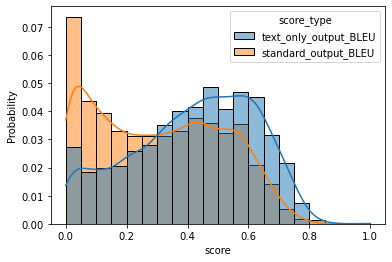

BLEU score has difference 0.147 (text_only_output_BLEU-standard_output_BLEU); test stat = 3420768.500 (p=6.035E-224)


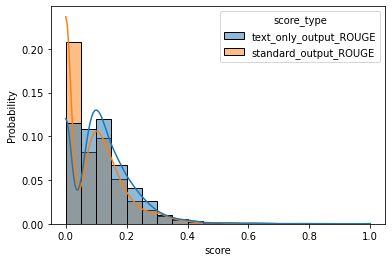

ROUGE score has difference 0.031 (text_only_output_ROUGE-standard_output_ROUGE); test stat = 3525205.500 (p=5.256E-82)


In [8]:
## plot distributions of scores
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import wilcoxon
score_types = ['BLEU', 'ROUGE']
for score_type_i in score_types:
    score_cols = list(filter(lambda x: score_type_i in x, test_data.columns))
    flat_score_data_i = pd.melt(test_data.loc[:, score_cols], value_vars=score_cols, var_name='score_type', value_name='score')
    sns.histplot(x='score', hue='score_type', data=flat_score_data_i, bins=20, kde=True, stat='probability')
    plt.show()
    ## compare score distributions
    scores_1 = test_data.loc[:, score_cols[0]].values
    scores_2 = test_data.loc[:, score_cols[1]].values
    score_med_diff = np.median(scores_1) - np.median(scores_2)
    test_stat, p_val = wilcoxon(scores_1, scores_2)
    print(f'{score_type_i} score has difference {"{:1.3f}".format(score_med_diff)} ({score_cols[0]}-{score_cols[1]}); test stat = {"{:1.3f}".format(test_stat)} (p={"{:.3E}".format(p_val)})')

The text-only model consistently outperforms the "stupid" standard model.

### Compare against reader-aware model
We have trained a model with reader "tokens" (e.g. `<US_AUTHOR>`), and now we investigate whether that helped performance or not.

In [28]:
import torch
author_text_test_data = torch.load('../../data/reddit_data/author_text_data/author_type_advice_subreddit_author_val_data.pt')['train']
author_text_test_data_ids = author_text_test_data['article_id']
print(author_text_test_data.shape)

(26509, 6)


In [29]:
text_test_data = torch.load('../../data/reddit_data/advice_subreddit_val_data.pt')['train']
# get IDs for merging
text_test_data_ids = text_test_data['article_id']
print(text_test_data.shape)

(26232, 6)


In [34]:
len(set(author_text_test_data['article_id']) & set(text_test_data['article_id']))

10708

In [30]:
print(len(set(text_test_data['target_text']) & set(author_text_test_data['target_text'])))

6164


In [4]:
## show example posts with author tokens
import re
from collections import Counter
author_token_matcher = re.compile('<[A-Z0-9_]+>')
assert author_token_matcher.search('this is an example post <US_AUTHOR>') is not None
author_token_counts = Counter()
for text_i in author_text_test_data['source_text']:
    author_token_match = author_token_matcher.search(text_i)
    if(author_token_match is not None):
        author_token_counts.update([author_token_match.group(0)])
print(author_token_counts)

Counter({'<EXPERT_PCT_0_AUTHOR>': 1080, '<RESPONSE_TIME_1_AUTHOR>': 722, '<RESPONSE_TIME_0_AUTHOR>': 407, '<US_AUTHOR>': 55, '<EXPERT_PCT_1_AUTHOR>': 49, '<NONUS_AUTHOR>': 25})


We don't have a huge number of reader tokens but enough to potentially trigger different responses. 

Let's subset the data to just look at the instances with reader information.

In [5]:
## get generated text
import gzip
author_model_gen_text = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_output_text.gz', 'rt')))
text_model_gen_text = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))

In [6]:
## get test data
import pandas as pd
text_data_cols = ['source_text', 'target_text', 'article_id']
test_data_df = pd.DataFrame([
    author_text_test_data[data_col]
    for data_col in text_data_cols
], index=text_data_cols).transpose()

In [7]:
print(len(author_model_gen_text))
print(len(text_model_gen_text))

26755
25523


In [8]:
print(len(author_model_gen_text))
print(len(author_text_test_data_ids))

26755
26755


In [16]:
## combine generated data
import pandas as pd
text_model_gen_data = pd.DataFrame([
    text_model_gen_text,
    text_test_data_ids,
], index=['text_only_output', 'article_id']).transpose()
author_model_gen_data = pd.DataFrame([
    author_model_gen_text,
    author_text_test_data_ids,
], index=['author_text_output', 'article_id']).transpose()
output_data = pd.merge(text_model_gen_data, author_model_gen_data, on='article_id', how='inner')
output_data.drop_duplicates(['text_only_output', 'article_id'], inplace=True)
output_data.drop_duplicates(['author_text_output', 'article_id'], inplace=True)
print(output_data.shape)
combined_test_data = pd.merge(test_data_df, output_data, on='article_id', how='right')
combined_test_data.drop_duplicates(['article_id', 'text_only_output', 'author_text_output'], inplace=True)
print(combined_test_data.shape)

(1167, 3)
(1167, 5)


Compute overlap on all data.

In [20]:
## compute overlap scores
from data_helpers import compute_text_bleu
from rouge_score.rouge_scorer import RougeScorer
rouge_scorer = RougeScorer(['rougeL'], use_stemmer=True)
bleu_weights = [1.0, 0., 0., 0.]
output_cols = ['text_only_output', 'author_text_output']
for output_col in output_cols:
    combined_test_data = combined_test_data.assign(**{
        f'{output_col}_BLEU' : combined_test_data.apply(lambda x: compute_text_bleu(x.loc['target_text'], x.loc[output_col], weights=bleu_weights), axis=1),
        f'{output_col}_ROUGE' : combined_test_data.apply(lambda x: rouge_scorer.score(x.loc['target_text'], x.loc[output_col])['rougeL'].fmeasure, axis=1),
    })

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

In [22]:
combined_test_data.head()

,source_text,target_text,article_id,text_only_output,author_text_output,text_only_output_BLEU,text_only_output_ROUGE,author_text_output_BLEU,author_text_output_ROUGE
0,"Hi all, I'm relatively new to this sub but I'm...",Im assuming your a teenager?,ctfblt,If you were so entitled to play loud music at ...,"If you don't mind me asking, how old are you?",0.219512,0.000000,0.511111,0.000000
8,"First of all, I know how that sounds, but it's...","If so, what ages?",afl15b,Is that like socially acceptable?,Is that what you want to teach your children?,0.393939,0.000000,0.288889,0.153846
20,A little context here. I plan every date we ev...,INFO - has she said why she isn't comfortable ...,as29s9,And what does it look like for her?,"Also, what about a diaphragm?",0.441921,0.000000,0.315133,0.000000
22,"So, I have an 8 year old son from a previous r...",YTA for making a post about a weird love trian...,bac0se,"If it's in the name of your son, why does he h...","Also, what's the legalities on you two forming...",0.642884,0.000000,0.693142,0.080000
34,TLDR: I'm gay; friends jokingly call me a f\*g...,Are you looking for quick cash from the sale o...,bztamy,Like the history and etymology of it?,What's the big deal?,0.135130,0.148148,0.009343,0.080000


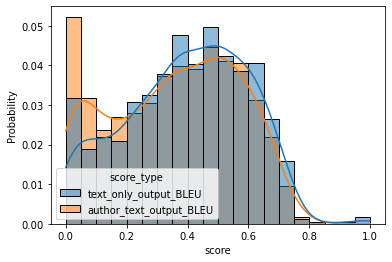

BLEU score has difference 0.037 (text_only_output_BLEU-author_text_output_BLEU); test stat = 282346.500 (p=4.941E-07)


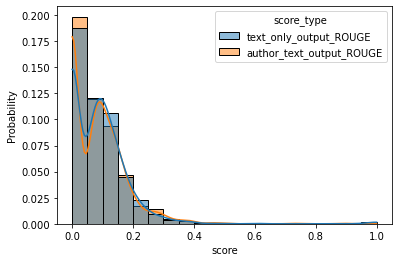

ROUGE score has difference 0.000 (text_only_output_ROUGE-author_text_output_ROUGE); test stat = 211670.000 (p=2.792E-01)


In [23]:
## plot distributions of scores
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import wilcoxon
score_types = ['BLEU', 'ROUGE']
for score_type_i in score_types:
    score_cols = list(filter(lambda x: score_type_i in x, combined_test_data.columns))
    flat_score_data_i = pd.melt(combined_test_data.loc[:, score_cols], value_vars=score_cols, var_name='score_type', value_name='score')
    sns.histplot(x='score', hue='score_type', data=flat_score_data_i, bins=20, kde=True, stat='probability')
    plt.show()
    ## compare score distributions
    scores_1 = combined_test_data.loc[:, score_cols[0]].values
    scores_2 = combined_test_data.loc[:, score_cols[1]].values
    score_med_diff = np.median(scores_1) - np.median(scores_2)
    test_stat, p_val = wilcoxon(scores_1, scores_2)
    print(f'{score_type_i} score has difference {"{:1.3f}".format(score_med_diff)} ({score_cols[0]}-{score_cols[1]}); test stat = {"{:1.3f}".format(test_stat)} (p={"{:.3E}".format(p_val)})')

OK! The author-aware model has a strong skew toward low scores, maybe because of overfitting.

What are some example sentences where the text-only model does better than the author-aware model?

In [27]:
pd.set_option('display.max_colwidth', 150)
## compute score differences
score_types = ['BLEU', 'ROUGE']
model_output_types = ['text_only_output', 'author_text_output']
for score_type_i in score_types:
    score_diff_var_i = f'{score_type_i}_diff'
    combined_test_data = combined_test_data.assign(**{
        score_diff_var_i : combined_test_data.loc[:, f'{model_output_types[0]}_{score_type_i}'] - combined_test_data.loc[:, f'{model_output_types[1]}_{score_type_i}']
    })
    ## show data with biggest differences
    combined_test_data.sort_values(score_diff_var_i, inplace=True, ascending=False)
    display(combined_test_data.loc[:, ['source_text', 'target_text',] + model_output_types + [score_diff_var_i]].head(10))

,source_text,target_text,text_only_output,author_text_output,BLEU_diff
2978,I’ve (23f) lived with my sister (36) and her kids for about 4 years now. I loved it at first because I finally got to have sibling bond with her. ...,INFO - why are you thinking about not telling her you’re moving out?,- why are you thinking about not telling her you’re moving out?,What’s the name of it?,0.816979
1089,"Amy (19) and I have never gotten along well but what she did recently took the cake.I have followed a strict vegan diet for 12 years now, it's som...","If you are feeling guilty about it, maybe you should apologise if you haven't already?",You've loved her for 2 years and you want her to stop and stop being rude to you?,"I'm sorry, what?",0.707811
1627,"So theres not too much to say, I guess I'm more curious in others opinions on this. I am an approx 22.5 year old man, I recently snagged a really...","It sounds like you didn't say anything to her, is the question about you expressing frustration while around roomate?",Is the sign definitely an officially sanctioned sign and not just a novelty sign someone put up on their usual spot?,What's your monthly income v. expenses?,0.702498
2300,"I'm a 5'8"" woman. Kind of tall for female I always thought. I don't see men in a romantic or sexual way if they're shorter than me. I've always fe...",Why the hell does it matter to you what she is doing when she's in her room alone?,"It's okay for a guy to have a preference, but it's not going to happen when you're 5'2?",See what I mean?,0.698501
151,I’m the dad of a 25 year old young woman who I love very much. I’ve been able to have a good relationship with my daughter and I enjoy my time wit...,"Is she not allowed to ever be married, or have any relations?",Is it just the company and nothing else she cares about?,What do I do?,0.679272
3164,"Long time lurker, first time asking a question, and using a throw away account.I'm in CA. I have a lease on a two bedroom apartment, where, per th...","Do you understand how the taxes work on a rental, both now and when you sell?","You said you have no written contract, do you have any written agreement to that effect?",What's the big deal?,0.658270
3512,"One of my friends committed suicide when I was young. I have never coped very well with the situation because I, myself, was dealing with behaviou...","What’s next, insisting you no longer shop at your favorite supermarket?",Does your loss of a friend affect your relationship with them?,&gt; What should I do?,0.656018
2368,"I have a good paying job ($100,000+) because of my skill in programming, I am renting a very nice apartment at the moment and have money saving up...","Has no one in this thread been to an apartment in NYC, let alone one with a family?",Are you planning to go further in debt for a house in the next 5 years?,&gt; What should I do?,0.647263
2566,"A little backstory: I’m the “manager” at my job, meaning my coworkers come to me first with questions &amp;amp; I resolve any issues before they g...","If the roles were reversed and you had a child, how upset would you be if he made that suggestion?",AITA for thinking I’m in the asshole for telling my friend she had an extraction at 4:30 am on a work shift?,What’s your credit score?,0.646983
605,"My friend is 27 and his wife is 26. They’ve been married for 5 years, dated for 9, and have a 4 year old daughter.I’ve known him since university....","YTA - “Like, bruh, why aren’t you still acting like a college bro with no family or responsibilities?",Info: do either of them have any friends or anything resembling a social life at all?,What’s wrong with you?,0.646162


,source_text,target_text,text_only_output,author_text_output,ROUGE_diff
2506,"Cars are paid off, I rent an apartment. Should I buy a house with all cash? Get a mortgage? Continue living in my apartment and put the money in i...",Are you ready/interested ?,Are you ready/interested?,Is she eating it out or some shit?,1.000000
2978,I’ve (23f) lived with my sister (36) and her kids for about 4 years now. I loved it at first because I finally got to have sibling bond with her. ...,INFO - why are you thinking about not telling her you’re moving out?,- why are you thinking about not telling her you’re moving out?,What’s the name of it?,0.960000
3421,"For over a decade I've only ever had a BoA checking and savings account. I'm fine with keeping my checking account, but I'd like to have a savings...",I recently opened a high yield savings account with CIT when it was 2.4% but the fed has been cutting rates so its down to like 2%?,I recently opened a high yield savings account with CIT when it was 2.4% but the fed has been cutting rates so its down to like 2%?,&gt; Is there a way for me to see a layout of what year taxes I have done or haven't done?,0.920000
1245,"Throw away so my girls don’t find out i’m angry bout this. And i’ll use fake namesOkay, i have 3 friends. 2 (Gabby and Chelsea) of which i met in ...",Is it a suit or nothing?,Is it a suit or nothing?,It’s not like you guys have Sunday dinner together each week right?,0.894737
2449,"I have never posted on reddit before i hope i'm posting this correctly please let me know if i've done it wrong, sorry if this is long or bad engl...","I hope you're doing okay OP, maybe talk to a professional about it?","I hope you're doing okay OP, maybe talk to a professional about it?",Have you had a conversation about this with her?,0.739130
634,"So since a few years my father has installed a few technical advancements in our house, it mainly revolves around the lightswitches but the ''syst...",How much time do you have?,Do you have kids?,&gt; Do I need a lawyer?,0.433333
2956,Considering two health insurance plans.Plan 1 has $5k deductible and $7k out of pocket maximum with 50% coinsurance after deductible.Plan 2 has $5...,Do you own a house?,Do you have a copay for the out of pocket max?,What's the rate on the car loan?,0.375000
3447,"Sorry for the long post, the full story requires some background.I’m currently in college and was born into a well off family, enough to be consid...",Is there no option to mail it directly to the insurance company?,&gt;is it really the right way?,&gt;What should I do?,0.315789
3415,So i am with a girl for like a year and we are having great time together. She is a great student(she is in Oxford for her llm) and generally she ...,What’s going on in the comment section?,What makes you think she's going to do coke again?,"If not, why not?",0.315789
211,"I am a butch lesbian and for the past 12 years I have had a short, men's style haircut. I'm not talking about a pixie cut that requires a lot of s...",Is a brokerage account like a 401k?,Is there a Supercuts by you?,If you don't want to fix it why are you still together?,0.307692


The author-aware model generates more generic questions that are less likely to provide useful information:
- `source_text`: `I’m the dad of a 25 year old young woman who I love very much.`
    - `target_text` : `Is she not allowed to ever be married, or have any relations?`
    - `text_only_output` : `Is it just the company and nothing else she cares about?`
    - `author_text_output` : `What do I do?`
- `source_text`: `A little backstory: I’m the “manager” at my job, meaning my coworkers come to me first with questions`
    - `target_text` : `If the roles were reversed and you had a child, how upset would you be if he made that suggestion?`
    - `text_only_output` : `AITA for thinking I’m in the asshole for telling my friend she had an extraction at 4:30 am on a work shift?`
    - `author_text_output` : `What’s your credit score?`

### Reader-aware model: test different reader input
Does the model generate different outputs if we provide different reader tokens as input?

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [32]:
## get sample data; remove reader tokens if included in input
import torch
import numpy as np
np.random.seed(123)
val_data = torch.load('../../data/reddit_data/author_text_data/author_type_advice_subreddit_author_data=tokens_val_data.pt')
sample_size = 1000
sample_idx = np.random.choice(list(range(len(val_data))), sample_size, replace=False)
sample_data = val_data.select(sample_idx, keep_in_memory=True)
tokenizer = torch.load('../../data/reddit_data/author_text_data/BART_tokenizer.pt')
reader_token_types = {
    'location' : ['<US_AUTHOR>', '<NONUS_AUTHOR>'],
    'expert' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'response' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
}
reader_token_type_lookup = {v1 : k for k,v in reader_token_types.items() for v1 in v}
reader_tokens = [v_i for k,v in reader_token_types.items() for v_i in v]
reader_token_ids = set(tokenizer.convert_tokens_to_ids(reader_tokens))
def remove_token_ids(data, invalid_token_ids, placeholder_id=-1):
    token_ids = data['source_ids']
    # replace every reader token with placeholder
    for invalid_token_id_i in invalid_token_ids:
        invalid_token_id_mask = token_ids == invalid_token_id_i
        token_ids[invalid_token_id_mask] = placeholder_id
    data['source_ids'] = token_ids
    return data
template_sample_data = sample_data.map(lambda x: remove_token_ids(x, reader_token_ids), keep_in_memory=True, load_from_cache_file=False)

  0%|          | 0/1000 [00:00<?, ?ex/s]

In [5]:
reader_val_data = list(filter(lambda x: len(set(x['source_ids'].tolist()) & set(reader_token_ids)) > 0, val_data))
print(f'{len(reader_val_data)}/{len(val_data)} data with reader tokens')

7295/37236 data with reader tokens


In [39]:
## replace placeholder token ID with reader token ID
from importlib import reload
import datasets
reload(datasets.arrow_dataset)
from datasets.arrow_dataset import concatenate_datasets
def replace_token_id(data, replacement_token, replacement_token_id_lookup):
    token_ids = data['source_ids']
    replace_token_mask = token_ids == replacement_token
    token_ids[replace_token_mask] = replacement_token_id_lookup[replacement_token]
    data['source_ids'] = token_ids
    return data
author_labels_sample_data = []
replacement_token_id = -1
for reader_token_id in reader_token_ids:
    replace_token_id_lookup = {replacement_token_id : reader_token_id}
    sample_data_i = template_sample_data.map(lambda x: replace_token_id(x, replacement_token_id, replace_token_id_lookup), keep_in_memory=True, load_from_cache_file=False)
    author_labels_sample_data.append(sample_data_i)
## version issue? concatenate doesn't work for older data
# author_labels_sample_data = concatenate_datasets(author_labels_sample_data)

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

In [8]:
## load model lol
import torch
from transformers import AutoModelForSeq2SeqLM
model_file = '../../data/reddit_data/author_text_data/question_generation_model/checkpoint-189000/pytorch_model.bin'
tokenizer = torch.load('../../data/reddit_data/author_text_data/BART_tokenizer.pt')
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir='../../data/model_cache/')
model.resize_token_embeddings(len(tokenizer))
model_weights = torch.load(model_file)
model.load_state_dict(model_weights)

<All keys matched successfully>

In [42]:
from data_helpers import generate_predictions
num_beams = 8
generation_method = 'beam_search'
author_labels_pred_data = []
for sample_data_i in author_labels_sample_data:
    pred_data_i = generate_predictions(
        model, sample_data_i, tokenizer, 
        generation_method=generation_method,
        num_beams=num_beams,
    )
    author_labels_pred_data.append(pred_data_i)

100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]


In [43]:
model = model.to('cpu')
torch.cuda.empty_cache()

What are some examples of questions that are different across reader groups?

Let's combine everything into a single ugly data table:

source_text | target_text | generated_text | reader_token

In [44]:
import pandas as pd
author_label_sample_pred_data = []
reader_token_category_lookup = {
    v_i : k
    for k,v in reader_token_types.items()
    for v_i in v
}
for data_i, pred_data_i, token_id_i in zip(author_labels_sample_data, author_labels_pred_data, reader_token_ids):
    reader_token_i = tokenizer.convert_ids_to_tokens(token_id_i)
    combined_data_i = pd.DataFrame([
        data_i['article_id'],
        data_i['source_text'],
        data_i['target_text'],
        pred_data_i,
    ], index=['article_id', 'source', 'target', 'pred']).transpose()
    combined_data_i = combined_data_i.assign(**{'reader_type' : reader_token_i, 'reader_category' : reader_token_category_lookup[reader_token_i]})
    author_label_sample_pred_data.append(combined_data_i)
author_label_sample_pred_data = pd.concat(author_label_sample_pred_data, axis=0)

In [45]:
display(author_label_sample_pred_data.head(20))

,article_id,source,target,pred,reader_type,reader_category
0,9bmv6p,"story and I'll keep it short; I have an abusive executive manager/supervisor, who, I will just say has been abusive, harassing, and disrespectful. This of course is just my side of the story, and I had done some research regarding the situation and in my state it didn't seem like I had very much evidence for a 'traditional' lawsuit involving harassment, mainly because it was very personal an not because I belong to any particular demographic, I'm a straight white male, so.&amp;#x200B;I had t...",Do you have a lawyer?,"Also, have you spoken to your lawyer about this?",<US_AUTHOR>,location
1,bibt2v,"away bro is sometimes on reddit. My wealthy father asked me to take time off of my job to install floors in my bros house he just bought him. I told him no making him cry.Background: my father and stepmother have always shown him more favoritism I'm a girl so obvious. They kicked my out when I was 14 because I was lazy and difficult after my accident ( am partially handicapped) they didn’t want my bad attitude around their son, understandable. They were kind to me and still paid for my bill...",Did you shed tears yourself?,"INFO: how old are you, and how dependent are you on your dad?",<US_AUTHOR>,location
2,bnqgdy,"Similar to another post so I was curious.I have 2 teenage boys and for my whole life, I’ve done their laundry. However, they repeatedly leave things in the pockets that ruin the load. I try to check but sometimes things slip through because they wear a lot of cargo pants and I don’t feel their pens. Going through every pocket adds a good 45 mins to my work.I told them time and again to make sure they weren’t leaving pens in their pockets, but they don’t listen. After another ruined load of c...","Also, are you currently the only one in the house who does laundry?",INFO: Did you know they were leaving the pens in their own laundry?,<US_AUTHOR>,location
3,9wxbiw,So I have a friend who I think is a good person but after a few group projects with her I have realized she’s insane. I want to just tell her in a nice way that I think she’s a little too intense and I’d rather not associate with her when our class together is over. But I also know she can react badly so I’m afraid of saying anything to her in fear of her freaking out and causing drama. I know I could just hide from her once our class is over but that just seems immature and we are adults he...,Pretty cold but if you don’t want to be friends &amp; don’t think she will respond well why bother going through the hassle?,Do you want to be her friend?,<US_AUTHOR>,location
4,9g3v99,"there anywhere on earth that gives loans based on actually have a person examine the situation and decide about the loan? All the companies obviously use a formula to decide if they will lend to you or not and these formulas currently would not offer me a loan but I’m in a situation that would be easily fixable and causes me a lot of hardship. A few years ago I got into a high interest debt cycle (I don’t need to be lambasted for this, I’m a moron and believe me I crucify myself in my head ...",What is your FICO credit score (use creditscorecard.com to find out)?,What's the formula?,<US_AUTHOR>,location
5,cwcq8n,"So I moved to a new apartment in December that is directly above a spin class. I honestly didn't really even think about it until they woke me up the first time. Since then it's been every single day. They crank Justin Bieber and the like every single morning starting at 6 at a volume where I can feel the bass reverberating through my floor. I've spoken to them quite a few times, usually with them claiming to not know how to work their PA system. Talked to the landlord about it a few times w...",And now you're hurting their business for your own reasons?,Are you allowed to work until 7:00?,<US_AUTHOR>,location
6,a2a7pc,"I'm writing a business plan regarding a business that processes funds for foreign artists in the U

In [46]:
author_label_sample_pred_data[author_label_sample_pred_data.loc[:, 'article_id']=='7witml']

,article_id,source,target,pred,reader_type,reader_category
17,7witml,"So this year on my W2, I mad just shy of $24k, and my wife made $8k. I paid out about $700 in federal taxes and $800 in state. She paid $19 to fed and maybe $100 to state. We both work at the same restaurant btw.I used TurboTax (for the first time ever) to estimate what we would be working with and ended up owing $360 (I was supposed to get a refund until I entered her w2). But have a refund of $86 from state.I feel like BOTH of us filled something out wrong. And we’re not in a position to b...",Bc y'all are right on the cusp?,How much did you withhold for state taxes?,<US_AUTHOR>,location
17,7witml,"So this year on my W2, I mad just shy of $24k, and my wife made $8k. I paid out about $700 in federal taxes and $800 in state. She paid $19 to fed and maybe $100 to state. We both work at the same restaurant btw.I used TurboTax (for the first time ever) to estimate what we would be working with and ended up owing $360 (I was supposed to get a refund until I entered her w2). But have a refund of $86 from state.I feel like BOTH of us filled something out wrong. And we’re not in a position to b...",Bc y'all are right on the cusp?,How much did you withhold for state taxes?,<NONUS_AUTHOR>,location
17,7witml,"So this year on my W2, I mad just shy of $24k, and my wife made $8k. I paid out about $700 in federal taxes and $800 in state. She paid $19 to fed and maybe $100 to state. We both work at the same restaurant btw.I used TurboTax (for the first time ever) to estimate what we would be working with and ended up owing $360 (I was supposed to get a refund until I entered her w2). But have a refund of $86 from state.I feel like BOTH of us filled something out wrong. And we’re not in a position to b...",Bc y'all are right on the cusp?,How much did you withhold for state taxes?,<EXPERT_PCT_0_AUTHOR>,expert
17,7witml,"So this year on my W2, I mad just shy of $24k, and my wife made $8k. I paid out about $700 in federal taxes and $800 in state. She paid $19 to fed and maybe $100 to state. We both work at the same restaurant btw.I used TurboTax (for the first time ever) to estimate what we would be working with and ended up owing $360 (I was supposed to get a refund until I entered her w2). But have a refund of $86 from state.I feel like BOTH of us filled something out wrong. And we’re not in a position to b...",Bc y'all are right on the cusp?,How much did you withhold for state taxes?,<EXPERT_PCT_1_AUTHOR>,expert
17,7witml,"So this year on my W2, I mad just shy of $24k, and my wife made $8k. I paid out about $700 in federal taxes and $800 in state. She paid $19 to fed and maybe $100 to state. We both work at the same restaurant btw.I used TurboTax (for the first time ever) to estimate what we would be working with and ended up owing $360 (I was supposed to get a refund until I entered her w2). But have a refund of $86 from state.I feel like BOTH of us filled something out wrong. And we’re not in a position to b...",Bc y'all are right on the cusp?,How much did you withhold for state taxes?,<RESPONSE_TIME_0_AUTHOR>,response
17,7witml,"So this year on my W2, I mad just shy of $24k, and my wife made $8k. I paid out about $700 in federal taxes and $800 in state. She paid $19 to fed and maybe $100 to state. We both work at the same restaurant btw.I used TurboTax (for the first time ever) to estimate what we would be working with and ended up owing $360 (I was supposed to get a refund until I entered her w2). But have a refund of $86 from state.I feel like BOTH of us filled something out wrong. And we’re not in a position to b...",Bc y'all are right on the cusp?,How much did you withhold for state taxes?,<RESPONSE_TIME_1_AUTHOR>,response


In [47]:
pd.set_option('display.max_colwidth', 500)
import numpy as np
np.random.seed(123)
for category_i, data_i in author_label_sample_pred_data.groupby('reader_category'):
    print(f'**** category={category_i} ****')
    reader_types_i = data_i.loc[:, 'reader_type'].unique()
    # remove duplicate articles
    article_id_counts_i = data_i.loc[:, 'article_id'].value_counts()
    data_i = data_i[data_i.loc[:, 'article_id'].apply(lambda x: article_id_counts_i.loc[x] <= len(reader_types_i))]
    reorg_data_i = pd.pivot(data_i, index='article_id', columns='reader_type', values='pred').reset_index()
    reorg_data_i = pd.merge(data_i.loc[:, ['article_id', 'source', 'target']], reorg_data_i, on='article_id')
    reorg_data_i.drop_duplicates(['article_id', 'target'], inplace=True)
    # limit to non-matches
    non_match_data_i = reorg_data_i[reorg_data_i.loc[:, reader_types_i[0]] != reorg_data_i.loc[:, reader_types_i[1]]]
    print(f'{non_match_data_i.shape[0]}/{reorg_data_i.shape[0]} examples where reader types changed the output')
    display(non_match_data_i.head(10))

**** category=expert ****
33/875 examples where reader types changed the output


,article_id,source,target,<EXPERT_PCT_0_AUTHOR>,<EXPERT_PCT_1_AUTHOR>
74,cb5unz,"I met a girl on a dating app recently and am having a bit of a hard time. We connected and had a chat and met up nearly a week ago for a date. It went well, and afterward I suggested (over the messenger app) that we meet again. She agreed so I suggested a time and date. She agreed to both, saying it worked for her.Then I went back to our chat log and noticed something that bothered me. I was the only one to EVER start the conversation. Not once over the 4 days we were talking did she messag...",Nta... However... Did you enjoy your in person date?,YTA - why do you think it's up to both parties?,If you haven’t reached out and she’s not interested then why bother?
104,egl4c2,", so I've always been a console gamer. I've been on PS4 for years, instead of getting the PS5 however I want to see about moving to PC instead. It makes more sense for me in my life being a computer science uni student. The main games I play are R6, Destiny and COD. Mainly FPS, although I'd love to try out mods on games like Minecraft and Skyrim. Could anyone give me a rough estimate on how much it would cost starting from scratch? Any estimate is much appreciated. Thanks!<RESPONSE_TIME_1_AU...","A good pc can range from $600-$3000+, what's your budget and what are you trying to achieve?",What's your budget?,What resolution will you be playing at?
252,ac5kyt,"'s happened a few times in the past and again tonight.She has a very selective diet due to certain medical conditions, but on the odd occasion orders food that obviously contains ingredients that places her in a lot of pain, bloating and cramps. She claims she forgot but I find it hard to believe considering the effects are severe and it's something she has had to deal with for years.She gets upset with me as I don't show her any sympathy because I consider it self-inflicted.AITA?<RESPONSE_T...",What's her reaction?,Maybe she’s had enough?,INFO: do you know if she has any of the side effects from the food she’s had before?
412,bu2kfh,"know my boyfriend is proposing soon (he has told me). He has also been very open about wanting me to have his dead mothers engagement ring. I do not want it. It’s ugly, old fashioned and I just find it creepy to wear a dead persons ring all the time. I’ve told him (I politely told him that I wouldn’t want his mums ring because it’s something very important for him and he should keep it for himself rather than giving it to me and having it as a symbol of our love type thing) and he says I’m ...",or re purpose the diamonds/ jewels into a ring style you like?,Is this a ring for him or for you?,Is this really the hill you want to die on?
498,d0h9rs,"feel like a bad friend. A close friend called me last night, asked if I could hang out with him, that he needed me. He came over to my office and we talked out on the balcony for a long while. He was very quiet at first, but then expressed through tears that he was in a very dire situation financially, that his small business was failing, that he felt like a total failure.He revealed that his wife can never know about the finances, this happened between them in the past and it would mean th...","If your friend has $50 to his name, how will 10k help?",Did he ask you to lend him $10k?,"Did he ask you to lend him $10,000?"
618,b6jnee,"went to a cabin with my friends and our SOs last weekend. My gf (of 3 years) and I got there first and my gf realized that she forgot tampons. The nearest drug store was almost an hour away. She wanted me to text all my friends and ask the to stop but I thought that was weird and told her to text their girlfriends instead. She only had one of their numbers and the girl didn't answer, so my gf texted my best friend Leroy on her own and he brought her tampons.The part that really rubbed me th...",Or does her saying “I love you” to her father get to you too?,"Also, how long are you going to be with this girl?","Also, how long h

**** category=location ****
42/875 examples where reader types changed the output


,article_id,source,target,<NONUS_AUTHOR>,<US_AUTHOR>
0,9bmv6p,"story and I'll keep it short; I have an abusive executive manager/supervisor, who, I will just say has been abusive, harassing, and disrespectful. This of course is just my side of the story, and I had done some research regarding the situation and in my state it didn't seem like I had very much evidence for a 'traditional' lawsuit involving harassment, mainly because it was very personal an not because I belong to any particular demographic, I'm a straight white male, so.&amp;#x200B;I had t...",Do you have a lawyer?,You are a straight white male and you are not a supervisor?,"Also, have you spoken to your lawyer about this?"
2,bibt2v,"away bro is sometimes on reddit. My wealthy father asked me to take time off of my job to install floors in my bros house he just bought him. I told him no making him cry.Background: my father and stepmother have always shown him more favoritism I'm a girl so obvious. They kicked my out when I was 14 because I was lazy and difficult after my accident ( am partially handicapped) they didn’t want my bad attitude around their son, understandable. They were kind to me and still paid for my bill...",Did you shed tears yourself?,"I mean, slowing the work?","INFO: how old are you, and how dependent are you on your dad?"
104,egl4c2,", so I've always been a console gamer. I've been on PS4 for years, instead of getting the PS5 however I want to see about moving to PC instead. It makes more sense for me in my life being a computer science uni student. The main games I play are R6, Destiny and COD. Mainly FPS, although I'd love to try out mods on games like Minecraft and Skyrim. Could anyone give me a rough estimate on how much it would cost starting from scratch? Any estimate is much appreciated. Thanks!<RESPONSE_TIME_1_AU...","A good pc can range from $600-$3000+, what's your budget and what are you trying to achieve?",What resolution will you be playing at?,What's your budget?
120,c1cmm9,"'m (27M) an immigrant from a certain east Asian developing country in the US. I came when I was 21, to do my Masters, and I'm currently working full TIME at a tech company.My parents want me to come back home to my home country. Their main reasons for this are 1. It is my home country hence my duty to come 'help the economy' and such. 2. The culture in US is not appropriate for raising kids (I come from a conservative family) 3. The 'white people' will never accept you as you own.I find all ...",Is it possible for you to visit more often or have them visit you?,I guess you're asking if you're the asshole for not wanting to help the economy?,"You’re not telling us the whole story, are you?"
142,e8ljat,"in 2017 i worked as a server at an italian place. one day this young (20s?) white couple come in and as soon as i introduce myself they instantly come across as creepy to me.while i'm taking they drinks order, the wife say to me 'i'm so sad obama is gone, i'm so sorry'.i'm a black guy btw.the whole time i'm serving, they complimenting me - the wife say she love my hair, husband say i'm the best waiter they ever had.they keep coming in over and over again for a month, sit in my area and repe...",Are you TA for refusing to serve a couple because they're white?,"NAH, but why are you acting like you did something wrong?","NAH, except for maybe your wife?"
238,aka8cv,"live in a very small apartment. All 3 bedrooms are very close to the kitchen. My one roommate and her boyfriend live in the kitchen. 80% of the time they are at home, they are in the kitchen. Usually they are pretty good about being quiet during the weeknights, so it's not too much of a problem. But weekends are bad. They will come home at 3am and start cooking a meal. Chopping veggies, Slamming cabinets, banging pots and pans. I understand it's the weekend and you're out late, but it's 3am...","I might make an exception for an occasional blow-out party (say, 1x a semester), but as a regular habit?",Ho

**** category=response ****
25/875 examples where reader types changed the output


,article_id,source,target,<RESPONSE_TIME_0_AUTHOR>,<RESPONSE_TIME_1_AUTHOR>
318,csbp6e,"am an only child who was raised on a single income. My parents made no attempt to hide the fact that I was a financial burden on them growing up. When I got my first good paying job my first pay check went straight to them, I didn't see a penny of it. I was told it was compensation for everything they'd given me. After that they took 50% of my paycheck each fortnight. When I started accumulating annual leave and talking about travelling, I was guilt tripped. Told they hadn't couldn't rememb...",You have shitty parents but I assume you probably already know that?,"INFO: how old are you, and do you live with them?",Should you be sending them on holiday as thanks?
416,ct4gv0,":avid gamer, mostly on my custom built pc. Nearly every night of the week after work. Bit of an anime /retro {80/90s) movie buff and enjoy listening to them on my home theater. I go out of my way to get releases, even if only on retro stuff like laserdisc, to get the original theatrical soundtracks if I can. I collect old tech, gaming computer office etc, and display it in my China cabinet. I don't date much, occasionally I get a date but usually it doesn't proceed because I don't want to g...","Wow ""help a nice woman build a happy life""?",How long have you been with this woman?,You’ve been with this girl for a decade and she called you a dick?
498,d0h9rs,"feel like a bad friend. A close friend called me last night, asked if I could hang out with him, that he needed me. He came over to my office and we talked out on the balcony for a long while. He was very quiet at first, but then expressed through tears that he was in a very dire situation financially, that his small business was failing, that he felt like a total failure.He revealed that his wife can never know about the finances, this happened between them in the past and it would mean th...","If your friend has $50 to his name, how will 10k help?",Did you feel good about yourself?,Did he ask you to lend him $10k?
608,b87wir,"few weeks ago my roommate and I drove to Chicago for St. Patrick's Day. Usually for these trips, I would split the cost of gas with him, because he uses his car and it wouldn't be fair to ask him to front the cost of gas. We try to split everything and be as fair as possible. During the day, he told me that a friend of his was flying in from O'Hare Airport and wanted a ride from there back to our school, and if he gave her a ride then she would pay for gas.So, his friend paid for the gas an...","NTA - say the friend bought a pizza for you and your roommate using your roommate’s phone, should you pay your roommate for half the pizza?","NTA, but why doesn't he ask you to pay for the gas?","If you were each paying for 1/2 the cost of gas, how is that fair?"
614,9rvm95,have already lost 8% and a few co workers said they are pausing investing. Thing is we get a 50% match from our company up to 6% and right now I am contributing 9%. So yeah... should I stop for a minute?<EXPERT_PCT_0_AUTHOR>,Would u rather buy when prices are high?,Are you pausing investing or just keeping it?,Is it a 10% match or a matching?
658,9dp22s,"boyfriend keeps talking about going for this new (better) job, and about going to the gym and all this self-improvement stuff. He hasn't done any of it, though.We're currently long distance. What can I do to support him and get him to do everything he says he wants to do?<EXPERT_PCT_0_AUTHOR>",Is it something he’s preparing for?,How does he feel about the gym?,What are the things he wants to do?
668,ege7wh,"friend was (reasonably) so upset that he left immediately. I had a long, calm conversation with her about why that was inappropriate during which she merely rationalized her point of view and said it was her house and she's allowed to say what she wants. She called me ""holier than thou"" for ""shoving"" my ""social dogmatism"" down her throat, which has really hurt my feelings. I

Some notable differences for different reader groups:

post|`EXPERT_PCT_0`|`EXPERT_PCT_1`
---|---|---
so I've always been a console gamer. I've been on PS4 for years, instead of getting the PS5 however I want to see about moving to PC instead. | What's your budget? | What resolution will you be playing at?
went to a cabin with my friends and our SOs last weekend. My gf (of 3 years) and I got there first and my gf realized that she forgot tampons. | Also, how long are you going to be with this girl? | Also, how long have you been dating?

post|`NONUS`|`US`
---|---|---
Everyone,I had a conversation with my manager today asking for a salary correction/adjustment based on the fact that I have just entered into the low end of my salary range for my pay grade after four years. | How does that compare to other work days? | How does that compare to other companies?
away bro is sometimes on reddit. My wealthy father asked me to take time off of my job to install floors in my bros house he just bought him. I told him no making him cry | I mean, slowing the work? | INFO: how old are you, and how dependent are you on your dad?

post|`RESPONSE_TIME_0`|`RESPONSE_TIME_1`
---|---|---
have already lost 8% and a few co workers said they are pausing investing. Thing is we get a 50% match from our company up to 6% and right now I am contributing 9%. | Are you pausing investing or just keeping it? | Is it a 10% match or a matching?
boyfriend keeps talking about going for this new (better) job, and about going to the gym and all this self-improvement stuff. | How does he feel about the gym? | What are the things he wants to do?

How do these generated questions compare to actual questions from people of different reader groups?

In [69]:
## get pairs of reader information
val_data_df = val_data.to_pandas()
# identify reader IDs
val_data_df = val_data_df.assign(**{
    'reader_token' : val_data_df.loc[:, 'source_ids'].apply(lambda x: list(set(x.tolist()) & set(reader_token_ids)))
})
reader_val_data_df = val_data_df[val_data_df.loc[:, 'reader_token'].apply(lambda x: len(x) > 0)]
reader_val_data_df = reader_val_data_df.assign(**{
    'reader_token' : reader_val_data_df.loc[:, 'reader_token'].apply(lambda x: tokenizer.convert_ids_to_tokens(x[0]))
})
reader_val_data_df = reader_val_data_df.assign(**{
    'reader_group' : reader_val_data_df.loc[:, 'reader_token'].apply(reader_token_type_lookup.get)
})
print(f'{reader_val_data_df.shape[0]}/{val_data_df.shape[0]} data with reader ID')
display(reader_val_data_df.head())

7295/37236 data with reader ID


,article_id,attention_mask,source_ids,source_text,target_ids,target_text,reader_token,reader_group
29941,9cf3p9,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]","[0, 133, 874, 20573, 117, 8850, 2856, 7, 5694, 50, 932, 1493, 13185, 101, 14, 4, 12606, 2387, 595, 2969, 16, 14, 114, 47, 33, 5, 1735, 9, 2057, 110, 40300, 868, 1425, 1567, 1169, 35, 3226, 10, 1126, 19, 6, 224, 6, 10, 262, 207, 1013, 773, 731, 6, 6532, 1009, 41, 915, 19, 6, 224, 6, 10, 231, 207, 1013, 773, 731, 6, 6968, 197, 25915, 25, 203, 9, 110, 418, 25, 678, 1567, 2746, 160, 5, 1126, 36, 24872, 218, 75, 342, 13540, 3785, 12606, 418, 1567, 5, 915, 238, 142, 5, 434, 9, 5, 701, 9, ...]","The below assumes no employer matches to contributions or anything else fancy like that.**My current understanding is that if you have the options of putting your expendable income towards either:* a debt with, say, a 7% annual interest rate, OR * an investment with, say, a 6% annual interest rate,you should allocate as much of your money as possible towards paying off the debt (meaning don't put **any** money towards the investment), because the growth of the cost of the debt is greater tha...","[0, 2264, 915, 34, 10, 8045, 731, 9, 671, 9, 231, 207, 116, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",What investment has a guaranteed rate of return of 6%?,<EXPERT_PCT_0_AUTHOR>,expert
29942,9cf3p9,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]","[0, 133, 874, 20573, 117, 8850, 2856, 7, 5694, 50, 932, 1493, 13185, 101, 14, 4, 12606, 2387, 595, 2969, 16, 14, 114, 47, 33, 5, 1735, 9, 2057, 110, 40300, 868, 1425, 1567, 1169, 35, 3226, 10, 1126, 19, 6, 224, 6, 10, 262, 207, 1013, 773, 731, 6, 6532, 1009, 41, 915, 19, 6, 224, 6, 10, 231, 207, 1013, 773, 731, 6, 6968, 197, 25915, 25, 203, 9, 110, 418, 25, 678, 1567, 2746, 160, 5, 1126, 36, 24872, 218, 75, 342, 13540, 3785, 12606, 418, 1567, 5, 915, 238, 142, 5, 434, 9, 5, 701, 9, ...]","The below assumes no employer matches to contributions or anything else fancy like that.**My current understanding is that if you have the options of putting your expendable income towards either:* a debt with, say, a 7% annual interest rate, OR * an investment with, say, a 6% annual interest rate,you should allocate as much of your money as possible towards paying off the debt (meaning don't put **any** money towards the investment), because the growth of the cost of the debt is greater tha...","[0, 2264, 915, 34, 10, 8045, 731, 9, 671, 9, 231, 207, 116, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",What investment has a guaranteed rate of return of 6%?,<RESPONSE_TIME_1_AUTHOR>,response
29943,9sl7wm,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]","[0, 89, 6, 2387, 1141, 8, 38, 32, 2107, 8, 389, 4067, 4, 1437, 1541, 613, 1068, 16, 215, 14, 52, 236, 7, 386, 4848, 11, 6809, 29, 36, 368, 7628, 1188, 6, 53, 31, 99, 38, 348, 1166, 6809, 29, 2045, 55, 1406, 25708, 13, 10, 3143, 9, 2188, 322, 1437, 166, 32, 258, 416, 602, 2093, 9, 5, 455, 1198, 12, 11755, 17936, 330, 6549, 3000, 4, 1437, 374

In [87]:
## get pairs of questions by article
import numpy as np
np.random.seed(123)
# reader_group_pair_sample_data = []
sample_size = 10
for reader_group_i, data_i in reader_val_data_df.groupby('reader_group'):
    print(f'**** reader group = {reader_group_i} ****')
    reader_tokens_i = data_i.loc[:, 'reader_token'].unique().tolist()
    article_question_counts_i = data_i.groupby('article_id').apply(lambda x: x.loc[:, 'reader_token'].nunique())
    valid_article_ids_i = article_question_counts_i[article_question_counts_i == len(reader_tokens_i)].index.tolist()
    sample_size_i = min(sample_size, len(valid_article_ids_i))
    sample_article_ids_i = np.random.choice(valid_article_ids_i, sample_size_i, replace=False)
    reader_group_pair_sample_data_i = []
    for article_id_j in sample_article_ids_i:
        data_j = data_i[data_i.loc[:, 'article_id']==article_id_j]
        # get one question per reader group
        reader_token_data_j = []
        for reader_token_k in reader_tokens_i:
            data_k = data_j[data_j.loc[:, 'reader_token']==reader_token_k].iloc[0, :]
            reader_token_data_j.append(data_k.loc['target_text'])
        text_j = data_j.loc[:, 'source_text'].iloc[0]
        reader_group_pair_sample_data_j = pd.Series([article_id_j, text_j] + reader_token_data_j)
        reader_group_pair_sample_data_j.index = ['article_id', 'source_text'] + reader_tokens_i
        reader_group_pair_sample_data_i.append(reader_group_pair_sample_data_j)
    reader_group_pair_sample_data_i = pd.concat(reader_group_pair_sample_data_i, axis=1).transpose()
    display(reader_group_pair_sample_data_i)

**** reader group = expert ****


,article_id,source_text,<EXPERT_PCT_0_AUTHOR>,<EXPERT_PCT_1_AUTHOR>
0,clvuye,"’ll keep this one short Reddit. She’s 6 months pregnant. Things going well. We’ve come up with a few baby names. She comes home from work yesterday and she told me that she was chatting to a co worker about our baby names. He points out that the girl name (the one I like the most by a long shot) a version of it (not the same name) has become common and they look it up, and according to a website it has. My partner says that we can’t choose that one now as she doesn’t like common names (but n...","Wow, am I the only one?","If you like a name and it doesn't fit your criteria, is there wiggle room or are you both firm?"
1,d9w459,"ife's sister is (or I guess was) pregnant. It's a big thing because she was trying for years with her boyfriend. Her health and the baby's health were excellent during checkins so in came flowing the gifts which was her idea. She made a list, gave it to family, and we all went to town.We bought her a crib ($1200) and some baby clothes (about $200) in preparation. She also received other gifts from other family members.She decided to terminate the pregnancy because her boyfriend left her afte...",INFO: are you quite sure she terminated because the father left?,This is more a question of why you think it’s ok to ask for a GIFT back?
2,bu4pla,"I’m 15 and my sister is 17 years old. We go to the same school, but usually she takes the bus 10 min earlier than me because I like to cut it a little closer in the morning. The bus stop is about a one minute walk from our house, basically just around one street corner. The street corner itself isn’t an actual corner but a used car sales yard. Since this month, the owner has hired a bunch of guys. To be honest I’m not sure what they’re even doing, I once saw them power wash the yard and the...",Why don't you walk a little in front of her or behind her to hear the abuse?,"YTA you have no idea what her experience has been, they could be saying horrible things to her and you’re here judging based on what???"
3,a0942n,was wondering if anyone had any thoughts on how much to keep in an emergency fund (as a percentage of monthly income) while trying to aggressively trying to pay off my car/ student loans? I've been putting about 10% of my paycheck each week into an emergency fund that's now reaching about a months pay. Is this enough to set aside for an emergency where I can now put these funds toward paying off my debt or should I continue saving up more? Any ideas would be greatly appreciated. <EXPERT_PCT...,What are the interest rates on your loans?,How often do you run into a situation where you need an entire month's worth of income absolutely right now immediately in cash with no other options?
4,c8qmye,"a year ago, I took in my niece(12) while her mother is away for a couple years. At first, everything was going well my daughter (18 at the time) didn’t mind since they got along but she eventually got tired and moved out. Once she moved, we only talked every once in a blue moon and I was upset. A couple months ago, we went to dinner and I mentioned I’m upset that she doesn’t speak to me and it turned into a big argument about how (I’m summarizing what she said here) “I never cared about her...","So you were a shitty mom who lived a shitty life and your daughter had to deal with the shitty situation you got yourself into, and now that you are doing better you think it should just be 'eh, get over it'?","If so, how do you expect your daughter to react?"
5,cti9w1,"got a note from my son's teacher (he's in kindergarten) yesterday saying that she would appreciate it if I didn't pack him ""these lavish snacks"" because snack time is meant to be something little to tide them off before lunch and before pick up time. And they should be able to ""easily fit in a small zip lock bag."" She urged me to make the fancy stuff for lunches because my son is the only one in class with an assortment of snacks. 

**** reader group = location ****


,article_id,source_text,<US_AUTHOR>,<NONUS_AUTHOR>
0,dbhs1d,"away for obvious reasons. Basically I [M42] got tattoos of the names of all 3 of my children. I got them going down my arm and they read from top to bottom (not actual names) ""Andy, Sara, Kate"". I had these tattoos all done at once after Kate was born knowing she would be my last. My oldest child Andy[T22] came out as trans and has decided she only goes by female pronouns now. My wife[F41] immediately supported her and made sure that I would too without any arguement or else she would divorc...",I also think we need INFO: were you initially resistant to her transition?,Are you a tattoo artist?
1,ba46dk,"all, thanks for reading, hopefully you guys can help me get a clear idea of what to do in this situation.So I'm based in Aus, if that changes anything.Basically my Dad's car is about to go kaput, he's looking into getting a replacement for the next phase of his life (he's mid 50's if that helps).Throughout his life, he's made some bad business decisions and as a result has terrible credit and has in fact gone bankrupt in the past, he's still on his way out but has around $30k outstanding wh...",But do you realize what a drag on relationships would it be when you will need to keep reminding him about payments EVERY MONTH?,A $60k car....?!???
2,e646sq,", I am the father. Second, I do believe that people should be allowed to wear whatever they want, but they can't be free from judgement. I had this babysitter, Emily, for about a month. She always seeme good, but today I got to leave work early due to a water leak, and came home me about 3 hours earlier. I opened the door, and I see her in just a bra and pants. She was surprised. I payed her for today, and told her that she wouldn't be babysitting our kids anymore. She then posted on NextDoo...",also important - how old is the child(ren) she's babysitting?,"Yes it's weird, but you couldn't have just asked her?"
3,ccrewt,"have been married to my husband for 1 year. We are both 38. He has a younger brother, 25, who has been dating his girlfriend (21) for 3 years. They are not engaged yet but she is very close with his family.My husband’s sister got married Friday evening. There was a church ceremony and a evening reception. Leading up to the event, me and the other women in the family shared what we were wearing to make sure nothing overlapped or was too similar. It all worked out fine.Then, at the evening re...","As a side note-So what that she is a super skinny, tall fashion model?","Why do bigger women always have to say they're ""normal"", like having a thinner body turns other women into abnormal oddities?"
4,dv9ogm,"husband and I have been trying for pregnancy for years now, and to cut a long story short it seems as though it will never be a possibility. It took a long time to come to terms with but we've gradually got there. Our entire family is aware of the journey we've been on and how much it meant to us. With that in mind, my husband and I came to his sister (Sarah) with a proposal.Sarah is in her early 30s, unmarried, and vocally against having children of her own. Despite this we thought she mig...","Wow, what the fuck is with this comment section??","If you have to pay for IVF (for yourself or a donor), and you can afford to pay your sister-in-law what a surrogate would normally be paid... then what's the problem?"
5,auzirj,"background: My grandfather just passed away at the end of January. He was closing in on 90 and lived a very full life and died very peacefully in his home which is exactly where he wanted to be. This is where the story gets very sticky, my grandfather lived in a cheap tract house and was very frugal. His only passions in life were woodworking and his garden. But to my huge surprised I was named as his sole heir with life changing money. With the house, everything in it and cash his estate w...",Did they not come due to hardships of some kind or because they legit didn't care?,How old are

**** reader group = response ****


,article_id,source_text,<RESPONSE_TIME_1_AUTHOR>,<RESPONSE_TIME_0_AUTHOR>
0,9nn04q,"don't have an account that I regularly use on Reddit, so I made one to ask this question. I am twenty (don't want to be exact) and I live in Texas and work full-time. My parents disowned me when I was around fifteen and kicked me out of the house for being gay and expressing political/religious opinions they disagreed with. Other than the occasional obscenity-laden phone call between us (maybe once a year on average), we don't speak.My parents are very poor and bad with money and once sever...",Wait— the sister with lung cancer is 4?,If you parents have done this twice how long do you think it's going to take for them to do it again?
1,cn7xfw,"mother and I don’t have the best relationship. We grew up in poverty and my parents both struggled to make ends meet working multiple jobs. When I was in high school, we received a settlement from an injury claim that was put in a trust. This allowed my parents to fund their new lifestyle, spoil my younger siblings, buy new cars, build a house etc., without working (trust paid them to be caregivers). Once the money from the trust was no longer available (about 3 yrs ago), my parents didn’t ...",“Only” two cars?,Maybe they need to go through what you did as a kid to learn a greater appreciation for what they have or are they too far gone in the I deserve stage?
2,clvuye,"’ll keep this one short Reddit. She’s 6 months pregnant. Things going well. We’ve come up with a few baby names. She comes home from work yesterday and she told me that she was chatting to a co worker about our baby names. He points out that the girl name (the one I like the most by a long shot) a version of it (not the same name) has become common and they look it up, and according to a website it has. My partner says that we can’t choose that one now as she doesn’t like common names (but n...","If you like a name and it doesn't fit your criteria, is there wiggle room or are you both firm?","Wow, am I the only one?"
3,casy8z,"friend (Anna) met a guy on Tinder who she really liked and went to his apartment and had sex on the first date. She told me about it after, and she had said before it happened that she didn't think he wanted anything serious (she wanted a relationship). She said she didn't tell her other friend because she would call Anna a slut. I told her she deserved to do what felt right to her and what made her happy. This was about 3 weeks ago, and the guy kind of jumped ship. He was nice to Anna and ...",So what if she had sex with him?,"You really think I'll never want to see her again because of some stupid thing along the lines of ""I already got what I want""?"
4,ch7vvo,"is an ongoing drama- so any feedback from you guys will be deeply appreciatedMale,40, two kids and wife,if that matters.About six families have come on a cruise together. One of the people who's come along is my cousin- she's been an alcoholic in the past and has been in rehab. Met up in Italy, got on the cruise and whatnot- everything was pretty cool for the first few hours. The trouble started when i took my kids down to the pool deck and met up with the rest of the gang. I ordered a beer...","So because she used to have a drinking problem, no one is allowed to have a drink when she's around?",NTA- So cause she can’t drink you can’t BS big steaming pile- Before the trip did she bring it up?
5,bxkjzz,"kids' school does not provide bussing, so it's on us to make arrangements. It's a 5 minute drive from our house, so it's not a huge deal. I dont have a job, but I do all the household chores and such, also the one that drives the kids to and from school.The only reason I think my husband should be the one to pick them up is because he drives right past the school on his way home during pick up time. Anytime I ask him to do it, he will agree (most of the time) but with a very, very heavy sig...",Does he help out with any of the chores relating to childcare?,D

Some notable differences for the reader groups:

post | `EXPERT_PCT_0` | `EXPERT_PCT_1`
--- | --- | ---
was wondering if anyone had any thoughts on how much to keep in an emergency fund (as a percentage of monthly income) while trying to aggressively trying to pay off my car/ student loans? | What are the interest rates on your loans? | How often do you run into a situation where you need an entire month's worth of income absolutely right now immediately in cash with no other options?
my girlfriend and I recently got engaged, and I figured it would be nicer to have her pick out her own ring rather then me guessing what she likes. Now I already know my girlfriend loves shiny things, but now she is absolutely adamant that she wants a real diamond ring. | Do you want children? | Can she see where you are coming from and your issues with the ethical part of buying a diamond?

post | `NONUS` | `US`
--- | --- | ---
Basically I [M42] got tattoos of the names of all 3 of my children. I got them going down my arm and they read from top to bottom (not actual names) "Andy, Sara, Kate" | Are you a tattoo artist? | I also think we need INFO: were you initially resistant to her transition?
I am the father. Second, I do believe that people should be allowed to wear whatever they want, but they can't be free from judgement. | Yes it's weird, but you couldn't have just asked her? | also important - how old is the child(ren) she's babysitting?

post | `RESPONSE_TIME_0` | `RESPONSE_TIME_1`
--- | --- | ---
Recently my wife and I have been struggling financially, and I'm trying to figure out what we can do to get ourselves moving in the right direction. | How 'bout dining out? | Seems like you can't afford - what are your daycare options?
My boyfriend and I were having sex and it was starting to hurt me. He asked if I was ok and I said no and that I wanted to stop. | But I also do not want to assume, maybe he will never do it again? | How are you feeling?

## Debug author embedding model
We learned author-embeddings from subreddit posting data, and we set up a very basic modified transformer model [here](../models/author_aware_model.py) that uses the embeddings as input to the encoder.

Let's see if it works!!

In [1]:
## generate random input, mask, embeddings as test
import torch
import numpy as np
np.random.seed(123)
torch.manual_seed(123)
dim = 100
N = 2
# generate random author embeds with small range
author_embeds = torch.randn(N, dim)
seq_len = 100
V = 100
vocab_ids = list(range(V))
input_ids = torch.LongTensor([np.random.choice(vocab_ids, seq_len, replace=True) for _ in range(N)])
seq_cutoff = 10
attention_mask = torch.LongTensor([[1,]*seq_cutoff + [0,]*(seq_len-seq_cutoff)]*N)
target_ids = torch.LongTensor([np.random.choice(vocab_ids, seq_len, replace=True) for _ in range(N)])

In [2]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import models.author_aware_model
reload(models.author_aware_model)
from models.author_aware_model import BartAuthorTextModel
from transformers.models.bart.configuration_bart import BartConfig
from transformers.models.bart import BartModel
config_file = '../../data/model_cache/BART_config.json'
config = BartConfig.from_json_file(config_file)
config.author_embeds = 100
model = BartAuthorTextModel(config)
model = model.to('cpu')
# model = BartModel(config)

In [3]:
model.train()
output = model(input_ids=input_ids, attention_mask=attention_mask, author_embeds=author_embeds)
print(output[0])

tensor([[[ 0.6516, -0.5578, -0.9554,  ..., -0.5759,  0.3654, -0.5219],
         [ 0.3736, -0.9776,  0.6224,  ..., -1.0483,  0.7486, -0.6883],
         [ 0.4770,  1.0020,  0.3127,  ..., -0.6324, -1.6979, -0.3413],
         ...,
         [ 1.9751,  1.0982, -0.3741,  ...,  0.2680, -1.0789, -2.4525],
         [-0.2343, -0.6831, -0.2433,  ..., -0.7390, -1.0432, -2.4422],
         [ 0.3352, -0.7717, -0.7986,  ..., -1.5298, -2.2892, -1.1793]],

        [[ 1.2259, -0.8335,  1.3157,  ...,  0.0812, -0.4894,  1.3935],
         [ 0.5466,  0.4023, -0.8808,  ..., -1.0903, -0.6636, -0.2997],
         [ 0.0691,  1.0655, -0.1485,  ...,  0.3121,  0.2321,  0.6809],
         ...,
         [ 0.4792,  2.0390,  0.2675,  ..., -1.6107, -1.5435, -0.9684],
         [-2.2086, -0.2166,  1.7865,  ..., -0.3496,  0.6257, -1.4521],
         [ 0.7206, -0.8661, -0.5603,  ..., -0.5563, -1.8545, -1.3418]]],
       grad_fn=<NativeLayerNormBackward>)


In [4]:
## test loss w/ fake training funcs
lm_head = torch.nn.Linear(config.d_model, model.shared.num_embeddings, bias=False)
loss_fct = torch.nn.CrossEntropyLoss()

In [7]:
lm_logits = lm_head(output[0])
masked_lm_loss = loss_fct(lm_logits.view(-1, config.vocab_size), target_ids.view(-1))

In [8]:
masked_lm_loss.backward()

In [9]:
# make sure we didn't ruin the weights w/ backprop
output_2 = model(input_ids=input_ids, attention_mask=attention_mask, author_embeds=author_embeds)
print(output_2[0])

tensor([[[-2.7901e-01, -1.3078e-01, -4.5747e-01,  ...,  4.8307e-01,
           4.4704e-01,  6.9702e-03],
         [-2.7366e-01,  1.0041e+00, -8.9286e-04,  ...,  7.2459e-01,
           8.4848e-01,  2.2203e-01],
         [ 6.3848e-02,  1.8505e+00,  2.1501e+00,  ..., -7.7991e-01,
          -2.1526e+00, -9.9272e-02],
         ...,
         [ 6.3677e-01,  6.4335e-02,  7.6416e-01,  ...,  2.3048e-01,
          -2.6376e-01, -2.7145e+00],
         [-6.4440e-01, -8.5554e-02,  9.1620e-01,  ..., -1.2012e+00,
          -9.9757e-01, -2.4378e+00],
         [-4.5914e-01, -9.1730e-01, -9.8352e-02,  ..., -1.0832e+00,
          -2.3885e+00, -1.0373e+00]],

        [[-5.9436e-02,  1.2172e+00,  3.7521e-01,  ..., -3.9833e-01,
           9.8887e-01,  6.4541e-01],
         [-3.4634e-01,  5.3082e-01, -1.5368e+00,  ..., -3.1839e-01,
          -3.9679e-01, -1.5523e+00],
         [-8.5324e-01,  1.2470e+00, -1.1909e+00,  ...,  3.3942e-01,
          -1.3679e-01, -6.1646e-01],
         ...,
         [ 5.9561e-01,  7

Now that we know the model technically works, let's try using the training scheme we've used before.

In [1]:
## build toy dataset for training
## generate random input, mask, embeddings as test
import torch
import numpy as np
np.random.seed(123)
torch.manual_seed(123)
dim = 100
N = 100
# generate random author embeds with small range
author_embeds = torch.randn(N, dim)
seq_len = 100
V = 100
vocab_ids = list(range(V))
input_ids = torch.LongTensor([np.random.choice(vocab_ids, seq_len, replace=True) for _ in range(N)])
seq_cutoff = 10
attention_mask = torch.LongTensor([[1,]*seq_cutoff + [0,]*(seq_len-seq_cutoff)]*N)
target_ids = torch.LongTensor([np.random.choice(vocab_ids, seq_len, replace=True) for _ in range(N)])

In [2]:
# convert data to dict, then to dataset lol
from datasets.arrow_dataset import Dataset
training_data_dict = {
    'input_ids' : list(map(lambda x: input_ids[x, :], range(N))),
    'attention_mask' : list(map(lambda x: attention_mask[x, :], range(N))),
    'target_ids' : list(map(lambda x: target_ids[x, :], range(N))),
    'author_embed' : list(map(lambda x: author_embeds[x, :], range(N))),
}
training_data = Dataset.from_dict(training_data_dict)
print(training_data)

Dataset({
    features: ['input_ids', 'attention_mask', 'target_ids', 'author_embed'],
    num_rows: 100
})


We've collect the author embedding data for real, so let's try training with it.

In [1]:
## reload data lol
import os
os.environ['CUDA_VISIBLE_DEVICES']="2"
import torch
train_data = torch.load('../../data/reddit_data/author_text_data/author_embed_data/author_type_advice_subreddit_author_data=embeds_train_data.pt')
val_data = torch.load('../../data/reddit_data/author_text_data/author_embed_data/author_type_advice_subreddit_author_data=embeds_val_data.pt')

In [2]:
tmp = torch.load('../../data/reddit_data/advice_subreddit_train_data.pt')['train']
print(tmp)

Dataset(features: {'article_id': Value(dtype='string', id=None), 'source_text': Value(dtype='string', id=None), 'target_text': Value(dtype='string', id=None), 'source_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'target_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 136842)


In [3]:
# print(tmp[0]['source_ids'])
# print(train_data[0]['source_ids'])
print(type(train_data))
print(type(tmp))

<class 'nlp.arrow_dataset.Dataset'>
<class 'nlp.arrow_dataset.Dataset'>


In [4]:
## load model
import os
from transformers import BartConfig
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import models.author_aware_model
reload(models.author_aware_model)
from models.author_aware_model import AuthorTextGenerationModel
config_file = '../../data/model_cache/BART_config.json'
config = BartConfig.from_json_file(config_file)
config.author_embeds = 100
model = AuthorTextGenerationModel(config)
# tokenizer 
tokenizer = torch.load('../../data/reddit_data/author_text_data/BART_tokenizer.pt')

In [5]:
if('../models/question_generation/' not in sys.path):
    sys.path.append('../models/question_generation/')
if('../models/' not in sys.path):
    sys.path.append('../models/')
from question_generation.data_collator import T2TDataCollator
# data collator
data_collator = T2TDataCollator(
    tokenizer=tokenizer,
    model_type='bart',
    mode="training",
    using_tpu=False
)

In [7]:
from models.train_basic_question_generation import load_training_args
max_source_len = len(train_data[0]['source_ids'])
max_target_len = len(train_data[0]['target_ids'])
model_out_dir = '../../data/reddit_data/author_text_data/author_embed_data/'
train_data_file = '../../data/reddit_data/author_text_data/author_embed_data/author_type_advice_subreddit_author_data=embeds_train_data.pt'
val_data_file = '../../data/reddit_data/author_text_data/author_embed_data/author_type_advice_subreddit_author_data=embeds_val_data.pt'
training_args = load_training_args(model_out_dir, train_data_file, model_out_dir, val_data_file, max_source_len, max_target_len, model_type='bart')

In [8]:
## load trainer
from question_generation.trainer import Trainer
# from transformers import Trainer as HFTrainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=data_collator,
#     label_smoothing=0,
)

In [9]:
print(train_data[0])

{'author_embeds': tensor([ 1.5167,  0.3106, -0.6342, -1.2964, -1.0975, -1.5022,  0.9073, -0.3184,
        -0.1609,  0.2130, -0.2104, -0.1191, -0.2256, -1.3445, -0.5157,  0.2125,
        -1.5838,  0.7030,  1.2237,  0.2690,  0.3487,  0.3686, -0.8598,  0.9912,
        -1.1501, -0.1328, -0.7304, -0.9461, -0.2770, -1.1121, -0.3626, -0.5528,
         1.3337, -1.9171,  1.8876, -0.2962,  2.2884,  1.7933, -0.7100,  1.4508,
        -0.2511, -1.6915, -0.0992, -0.8142,  0.4367,  0.4682, -1.3442,  0.9637,
        -0.3345, -1.3521,  0.8115, -0.7210,  0.9157,  0.4766,  1.2743,  0.0591,
        -0.1518, -0.9050,  0.2859,  0.5329,  2.4608,  0.1200, -0.8608,  2.6834,
         0.8878, -0.1591, -1.0457, -0.4177, -0.3860,  0.4915, -0.2983, -2.3016,
        -2.2901, -1.9878, -1.3114, -0.4777,  1.7521, -1.7085, -2.7099, -0.7320,
        -1.5596,  0.1548, -1.3497, -1.3017,  0.6109, -0.8333,  0.3387,  0.6357,
        -0.8307,  0.4502,  0.4211, -0.3679,  0.0526,  1.2103,  0.6981,  0.4398,
         2.0487,  0.28

In [10]:
trainer.train(model_out_dir)

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [22]:
print(tmp[0])
print(train_data[0])

{'source_ids': tensor([   0, 2387,  628,  ...,    1,    1,    1]), 'target_ids': tensor([   0, 8275,   47,  563,   15, 8180, 3859,  116,    2,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1]), 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0])}
{'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0])}
